## Uncertainty analysis with adjustment factors - Canada
- Initial grid search
- Fine-tuning Cell2Fire and Cell2Fire with BBO

#### Global fine-tuning of adjustment factors (HROS, BROS, FROS, Eccentricity)
- Initial tuning: Since adjustment factors are not characterized by any known data distribution, we set an initial bounds of [0,3] with an interval of 0.5
- Fine-tuning: 
    * HROS Factor = [0.5, 1] with interval of 0.1
    * BROS Factor = [2, 3] with interval of 0.5
    * FROS Factor = [2.5, 3] with interval of 0.1
    * Eccentricity factor = [2.5, 3] with interval of 0.1
    * Fire Period Length = [0.1, 0.5] with interval of 0.1

In [7]:
# Libraries
import os, random, time, subprocess, glob
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path
from typing import Optional
from random import randint
import rasterio
import tqdm
import matplotlib.pyplot as plt
import utils.DataGeneratorC2 as DataGenerator
import warnings
import seaborn as sns


# Metrics
from numpy import linalg as LA
from sklearn.metrics import f1_score
from skimage.metrics import structural_similarity as ssim

warnings.filterwarnings('ignore')

In [8]:
# Turns a dictionary into a class
class Dict2Class(object):
    def __init__(self, my_dict):
        for key in my_dict:
            setattr(self, key, my_dict[key])

# Pre-processing: Generate the Data.csv file for the C++ core
def generateDataC(args):
    dataName = os.path.join(args.InFolder, "Data.csv")
    if os.path.isfile(dataName) is False:
        print("Generating Data.csv File...")
        DataGenerator.GenDataFile(args.InFolder)    
                    
# Run C++ Sim 
def run(cell2fire_path, args, verbose=False):
    # Parse args for calling C++ via subprocess        
    # old: execArray=[os.path.join(os.getcwd(),'Cell2FireC/Cell2Fire'), 
    execArray=[os.path.join(cell2fire_path,'Cell2Fire'), 
               '--input-instance-folder', args.InFolder,
               '--output-folder', args.OutFolder if (args.OutFolder is not None) else '',
               '--ignitions' if (args.ignitions) else '',
               '--sim-years', str(args.sim_years),
               '--sim', str(args.Simulator),
               '--nsims', str(args.nsims),
               '--grids' if (args.grids) else '', 
               '--final-grid' if (args.finalGrid) else '',
               '--Fire-Period-Length', str(args.input_PeriodLen),
               '--output-messages' if (args.OutMessages) else '',
               '--weather', args.WeatherOpt,
               '--nweathers', str(args.nweathers),
               '--ROS-CV', str(args.ROS_CV),
               '--IgnitionRad', str(args.IgRadius), 
               '--seed', str(int(args.seed)),
               '--nthreads', str(int(args.nthreads)),
               '--ROS-Threshold', str(args.ROS_Threshold),
               '--HFI-Threshold', str(args.HFI_Threshold),
               '--HFactor', str(args.HFactor),
               '--BFactor', str(args.BFactor),
               '--FFactor', str(args.FFactor),
               '--EFactor', str(args.EFactor),
               '--bbo' if (args.BBO) else '',
               '--mcnumber', str(args.mcnumber),
            #    '--scenario' if str(args.scenario) else '',
               '--HarvestPlan', args.HCells if(args.HCells is not None) else '',
               '--EllipticalOption', str(args.EllipticalOption),
               '--LBFormula', str(args.LBFormula),
               '--kopt' if (args.KOPT) else '',
               '--verbose' if (args.verbose) else '',]


    # Print exec array
    if verbose:
        print('ExecArray:', ' '.join(execArray))
    
    # Output log
    if args.OutFolder is not None:
        if os.path.isdir(args.OutFolder) is False:
            os.makedirs(args.OutFolder)
        LogName = os.path.join(args.OutFolder, "LogFile.txt")
    else:
        LogName = os.path.join(args.InFolder, "LogFile.txt")   

    # Perform the call
    with open(LogName, 'w') as output:
        proc = subprocess.Popen(execArray, stdout=output)
        proc.communicate()
    return_code = proc.wait()
    if (return_code != 0):
        raise RuntimeError(f'C++ returned {return_code}.\nTry looking at {LogName}.') 

    # # End of the replications
    # print("End of Cell2FireC execution...")

In [9]:
'''
Metrics:
- ADI
- Sorensen index (Dice)
- F1-score
'''

def compute_ADI(result_c2f, result_ref):

    # Flatten
    result_c2f = result_c2f.to_numpy().flatten()
    result_ref = result_ref.flatten()        

    # Intersection (I) - Cells burned in both models
    intersection = np.sum((result_c2f == 1) & (result_ref == 1))

    # Overestimation (OE) - Burned in Cell2Fire but NOT in REF
    overestimation = np.sum((result_c2f == 1) & (result_ref == 0))

    # Underestimation (UE) - Burned in REF but NOT in Cell2Fire
    underestimation = np.sum((result_c2f == 0) & (result_ref == 1))

    # Calculate ADI (Area Difference Index)
    ADI = (overestimation + underestimation) / intersection         # ADI (Area Difference Index)
    ADIue = underestimation / intersection                          # ADIue (Underestimation Index)
    ADIoe = overestimation / intersection                           # ADIoe (Overestimation Index)

    # Edge effect
    if intersection == 0:
        ADI, ADIue, ADIoe = np.nan, np.nan, np.nan
        # print("No overlap between the predicted and observed fire perimeters. ADI metrics cannot be calculated.")

    return ADI, ADIue, ADIoe


def compute_sorensen(result_c2f, result_ref):

    # Flatten
    result_c2f = result_c2f.to_numpy().flatten()
    result_ref = result_ref.flatten()        

    # Calculate intersection (correctly predicted burned area)
    intersection = np.sum((result_c2f == 1) & (result_ref == 1))

    # Calculate total burned areas
    area_cell2fire = np.sum(result_c2f == 1)
    area_ref = np.sum(result_ref == 1)

    # Sorensen-Dice Index (SDI) Calculation
    if (area_cell2fire + area_ref) == 0:
        SDI = np.nan  # Avoid division by zero if no burned area in both grids
    else:
        SDI = (2 * intersection) / (area_cell2fire + area_ref)

    return SDI

def compute_f1_score(result_c2f, result_ref):

    # Flatten
    result_c2f = result_c2f.to_numpy().flatten()
    result_ref = result_ref.flatten()        

    # Define burned and unburned regions
    # 1 = burned, 0 = unburned
    burned_cell2fire = (result_c2f == 1).astype(int)
    burned_ref = (result_ref == 1).astype(int)

    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    TP = np.sum((burned_cell2fire == 1) & (burned_ref == 1))  # Correctly predicted burned
    FP = np.sum((burned_cell2fire == 1) & (burned_ref == 0))  # Overestimated (False Positive)
    FN = np.sum((burned_cell2fire == 0) & (burned_ref == 1))  # Underestimated (False Negative)

    # Calculate Precision and Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Calculate F1 Score
    if (precision + recall) == 0:
        F1 = 0  # Avoid division by zero
    else:
        F1 = (2 * precision * recall) / (precision + recall)

    return F1, precision, recall

In [10]:
# Basic parameters and paths
BASE_PATH = '/Users/minho/Documents/GitHub/Cell2FireML/'
CELL2FIRE_PATH = os.path.join(BASE_PATH, 'Cell2FireW/')         # Cell2Fire binary
DATA_PATH = os.path.join(BASE_PATH, 'data/real/canada_dogrib')
OUTPUT_PATH = '/Users/minho/Documents/GitHub/Cell2FireML/results/Canada_weather'
# /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib

# Create output folder for MC-sampled simulation results
if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

## 1. No tune

In [18]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Parameters
INSTANCE = 'canada_dogrib'
N_THREADS = 1
sim = 'C'

# C2F Parameters (tuned)
_HFactor = np.arange(0, 3, 0.5)
_BFactor = np.arange(0, 3, 0.5)
_FFactor = np.arange(0, 3, 0.5)
_EFactor = np.arange(0, 3, 0.5)
_fperiod = np.arange(0, 2, 0.5)

In [19]:
# Set new instance
INSTANCE = 'dogrib'
out_name = 'dogrib_no_tune_weather'

with tqdm.tqdm(total=len(_HFactor) * len(_BFactor) * len(_FFactor) * len(_EFactor) * len(_fperiod), 
        desc="Running...") as pbar:

    # Input instance
    INSTANCE_PATH = DATA_PATH

    # Create placeholders
    results = {"Instance":[], "HFactor":[], "BFactor":[], "FFactor":[], "EFactor":[], "fperiod":[],
            "ADI":[], "ADI_ue":[], "ADIoe":[], "F1":[], 
            "norm":[], "MSE":[], "area_c2f":[], "SSIM":[], "area_ref":[], "time":[]
            }
    cnt = 0

    # Load reference dataset (Real scar from Dogrib Fire)
    df_reference = pd.read_csv(os.path.join(DATA_PATH, 'real_scar_dogrib.csv'), header=None, delimiter=' ')
    df_ref = df_reference.to_numpy().flatten()

    # Loop
    for HFactor in _HFactor:
        for BFactor in _BFactor:
            for FFactor in _FFactor:
                for EFactor in _EFactor:
                    for fperiod in _fperiod:
        
                        OUT_PATH = os.path.join(OUTPUT_PATH, out_name, "sensitivity" + str(cnt))
                        if not os.path.exists(os.path.join(OUTPUT_PATH, out_name)):
                            os.mkdir(os.path.join(OUTPUT_PATH, out_name))                        
                        if not os.path.exists(OUT_PATH):
                            os.mkdir(OUT_PATH)
                            
                        # Cell2Fire options
                        args = {
                            'InFolder': INSTANCE_PATH,
                            'OutFolder': OUT_PATH,
                            'ignitions': True,
                            'sim_years': 1,
                            'sim': str(sim),
                            'nsims': 1,
                            'mcnumber': cnt,
                            'Simulator': sim,
                            'grids': False, 
                            'finalGrid': True,
                            'input_PeriodLen': fperiod,
                            'OutMessages': False,
                            'WeatherOpt': 'rows',
                            'nweathers': 1,
                            'ROS_CV': 0.0,
                            'IgRadius': 0, 
                            'seed': 123,
                            'ROS_Threshold':0.0,
                            'HFI_Threshold':0.0,
                            'HFactor':HFactor,
                            'BFactor':BFactor,
                            'FFactor':FFactor,
                            'EFactor':EFactor,
                            'nthreads':N_THREADS,
                            'BBO': False,
                            'HCells': None,
                            'verbose': False,
                            'EllipticalOption':1, 
                            'LBFormula':0, 
                            'KOPT':False,
                            'verbose':False
                        }

                        # Convert to object
                        args_obj = Dict2Class(args)
                
                        # Execution
                        start_time = time.time()
                        run(cell2fire_path=CELL2FIRE_PATH, args=args_obj, verbose=False)
                        end_time = time.time()
                        execution_time = end_time - start_time

                        # Load simulated and reference outputs
                        df_result = pd.read_csv(glob.glob(os.path.join(OUT_PATH, 'Grids/Grids1/ForestGrid*.csv'))[0], header=None)
                        df_result_npy = df_result.to_numpy().flatten()

                        # Compute evaluation metrics
                        ADI, ADIue, ADIoe = compute_ADI(df_result, df_ref)
                        # F1, precision, recall = compute_f1_score(df_result, df_farsite)


                        norm = LA.norm(df_result_npy - df_ref)
                        mse = ((df_result_npy - df_ref)**2).mean()
                        F1 = f1_score(df_ref , df_result_npy, average='macro')
                        ssim_sc = ssim(df_result_npy, df_ref, data_range=1)
                        area_cell2fire = len(df_result_npy[df_result_npy == 1])
                        area_ref = len(df_ref[df_ref == 1])

                        results['Instance'].append(cnt)
                        results['HFactor'].append(HFactor)
                        results['BFactor'].append(BFactor)
                        results['FFactor'].append(FFactor)
                        results['EFactor'].append(EFactor)
                        results['fperiod'].append(fperiod)
                        results['ADI'].append(ADI)
                        results['ADI_ue'].append(ADIue)
                        results['ADIoe'].append(ADIoe)
                        results['F1'].append(F1)
                        results['norm'].append(norm)
                        results['MSE'].append(mse)
                        results['SSIM'].append(ssim_sc)
                        results['area_ref'].append(area_ref)
                        results['area_c2f'].append(area_cell2fire)
                        
                        # results['Precision'].append(precision)
                        # results['Recall'].append(recall)
                        results['time'].append(execution_time)                    

                        cnt+=1
                        pbar.update(1)

    # Save  
    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(OUT_PATH, 'all_results_sensitivity_{}.csv'.format(INSTANCE))) # Save to file

Running...: 100%|██████████| 5184/5184 [1:47:33<00:00,  1.24s/it]  


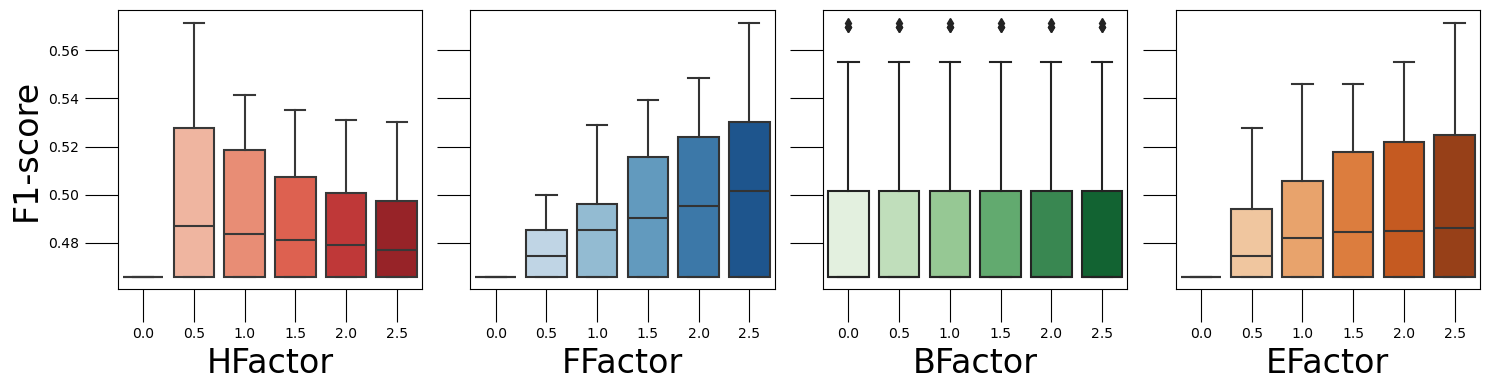

In [20]:
# F1-score
fig, ax = plt.subplots(1,4, figsize=(15,4), sharey=True)

for i, (metric, cmap) in enumerate(zip(['HFactor', 'FFactor', 'BFactor', 'EFactor'], ['Reds','Blues','Greens','Oranges'])):
    
    sns.boxplot(data=results_df, x=metric, y='F1', palette=cmap, ax=ax[i])
    
    ax[i].tick_params(axis='both', size=24)
    ax[i].set_ylabel('', size=24)
    ax[i].set_xlabel(metric, size=24)

ax[0].set_ylabel('F1-score', size=24)
plt.tight_layout()
plt.show()    

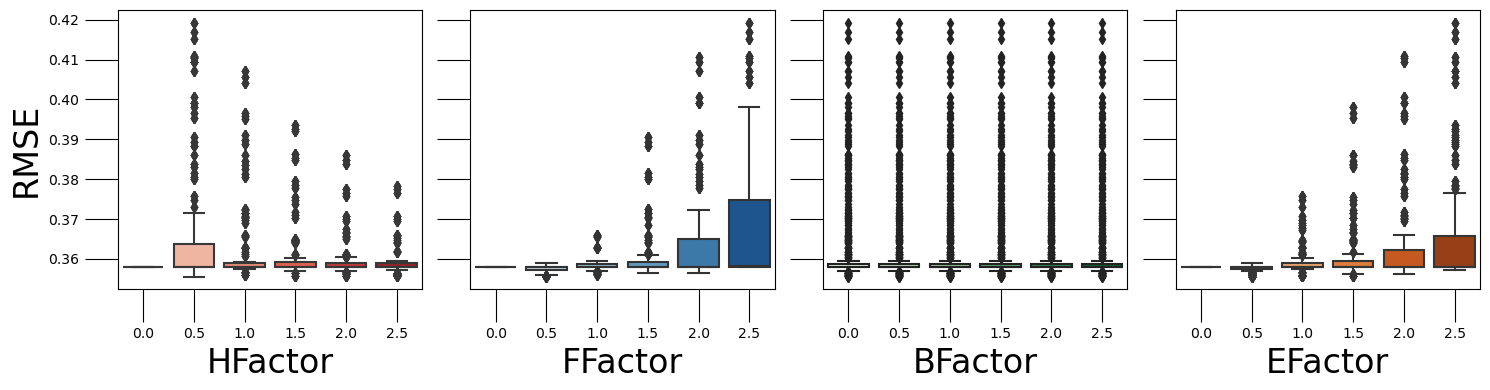

In [21]:
# RMSE
results_df['RMSE'] = np.sqrt(results_df['MSE'])

fig, ax = plt.subplots(1,4, figsize=(15,4), sharey=True)

for i, (metric, cmap) in enumerate(zip(['HFactor', 'FFactor', 'BFactor', 'EFactor'], ['Reds','Blues','Greens','Oranges'])):
    
    sns.boxplot(data=results_df, x=metric, y='RMSE', palette=cmap, ax=ax[i])
    
    ax[i].tick_params(axis='both', size=24)
    ax[i].set_ylabel('', size=24)
    ax[i].set_xlabel(metric, size=24)

ax[0].set_ylabel('RMSE', size=24)
plt.tight_layout()
plt.show()    

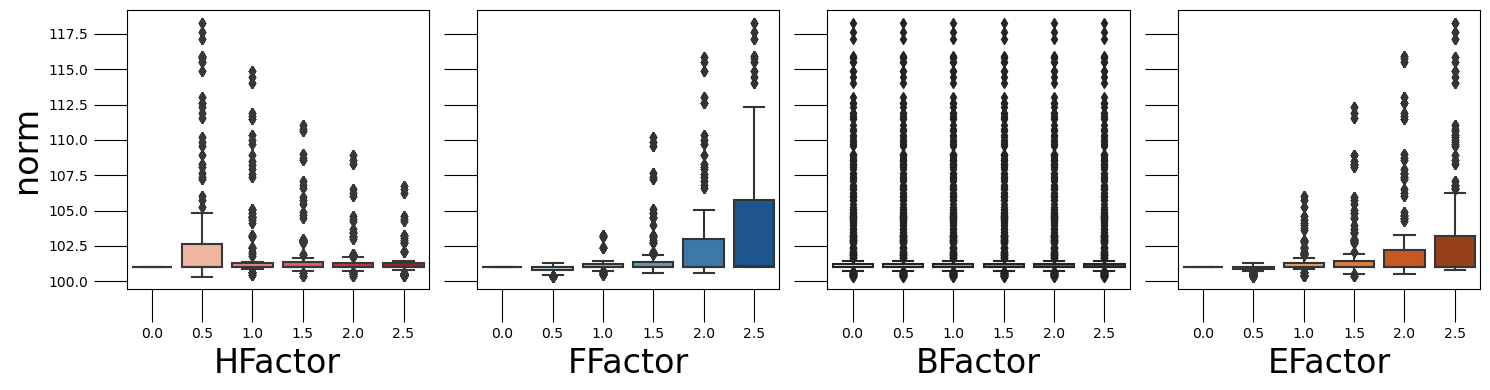

In [22]:
# Norm
fig, ax = plt.subplots(1,4, figsize=(15,4), sharey=True)

for i, (metric, cmap) in enumerate(zip(['HFactor', 'FFactor', 'BFactor', 'EFactor'], ['Reds','Blues','Greens','Oranges'])):
    
    sns.boxplot(data=results_df, x=metric, y='norm', palette=cmap, ax=ax[i])
    
    ax[i].tick_params(axis='both', size=24)
    ax[i].set_ylabel('', size=24)
    ax[i].set_xlabel(metric, size=24)

ax[0].set_ylabel('norm', size=24)
plt.tight_layout()
plt.show()    

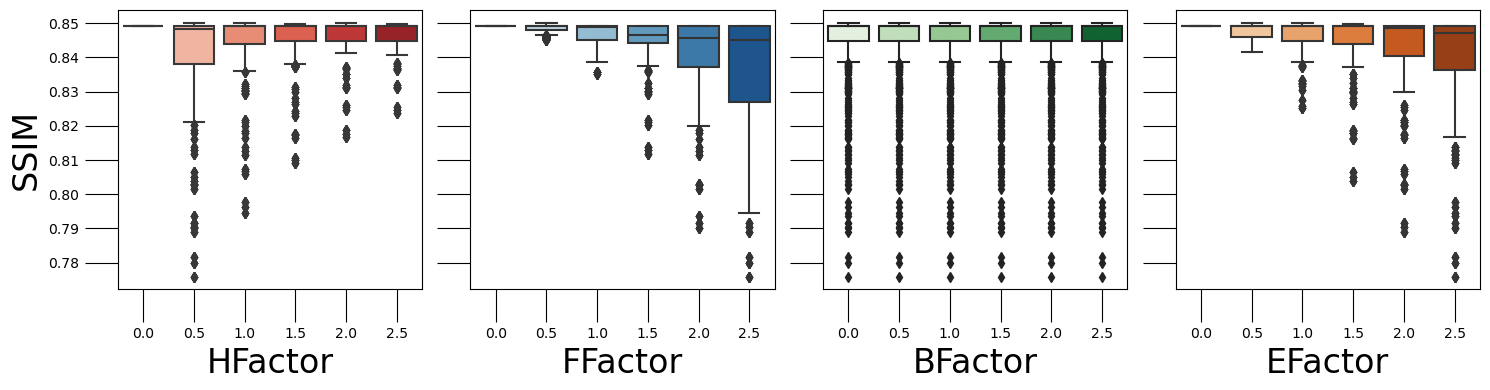

In [23]:
# SSIM
fig, ax = plt.subplots(1,4, figsize=(15,4), sharey=True)

for i, (metric, cmap) in enumerate(zip(['HFactor', 'FFactor', 'BFactor', 'EFactor'], ['Reds','Blues','Greens','Oranges'])):
    
    sns.boxplot(data=results_df, x=metric, y='SSIM', palette=cmap, ax=ax[i])
    
    ax[i].tick_params(axis='both', size=24)
    ax[i].set_ylabel('', size=24)
    ax[i].set_xlabel(metric, size=24)

ax[0].set_ylabel('SSIM', size=24)
plt.tight_layout()
plt.show()    

In [24]:
results_df[(results_df['HFactor'] == 0.5) & (results_df['FFactor'] == 2.5) & (results_df['EFactor'] == 2.5)].sort_values(by='F1')

,Instance,HFactor,BFactor,FFactor,EFactor,fperiod,ADI,ADI_ue,ADIoe,F1,norm,MSE,area_c2f,SSIM,area_ref,time,RMSE
1004,1004,0.5,0.0,2.5,2.5,0.0,10209.000000,10209.000000,0.000000,0.465842,101.039596,0.128236,1,0.849267,10210,1.145600,0.358101
1724,1724,0.5,2.5,2.5,2.5,0.0,10209.000000,10209.000000,0.000000,0.465842,101.039596,0.128236,1,0.849267,10210,0.854555,0.358101
1148,1148,0.5,0.5,2.5,2.5,0.0,10209.000000,10209.000000,0.000000,0.465842,101.039596,0.128236,1,0.849267,10210,1.349053,0.358101
1580,1580,0.5,2.0,2.5,2.5,0.0,10209.000000,10209.000000,0.000000,0.465842,101.039596,0.128236,1,0.849267,10210,0.986777,0.358101
1292,1292,0.5,1.0,2.5,2.5,0.0,10209.000000,10209.000000,0.000000,0.465842,101.039596,0.128236,1,0.849267,10210,1.022771,0.358101
1436,1436,0.5,1.5,2.5,2.5,0.0,10209.000000,10209.000000,0.000000,0.465842,101.039596,0.128236,1,0.849267,10210,1.191609,0.358101
1006,1006,0.5,0.0,2.5,2.5,1.0,6.418097,3.737819,2.680278,0.569774,117.605272,0.173732,7931,0.779756,10210,2.748584,0.416812
1582,1582,0.5,2.0,2.5,2.5,1.0,6.418097,3.737819,2.680278,0.569774,117.605272,0.173732,7931,0.779756,10210,2.474425,0.416812
1150,1150,0.5,0.5,2.5,2.5,1.0,6.418097,3.737819,2.680278,0.569774,117.605272,0.173732,7931,0.779756,10210,3.265747,0.416812
1294,1294,0.5,1.0,2.5,2.5,1.0,6.418097,3.737819,2.680278,0.569774,117.605272,0.173732,7931,0.779756,10210,2.564811,0.416812


## 2. Fine tune

In [38]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Parameters
INSTANCE = 'canada_dogrib'
N_THREADS = 1
sim = 'C'

# C2F Parameters
_HFactor = np.arange(0.5, 1, 0.1)
_BFactor = np.arange(2, 3, 0.5)
_FFactor = np.arange(2.5, 3, 0.1)
_EFactor = np.arange(2.5, 3, 0.1)
_fperiod = np.arange(0.1, 0.5, 0.1)

print("Number of trials: ", len(_HFactor) * len(_BFactor) * len(_FFactor) * len(_EFactor) * len(_fperiod))

Number of trials:  1000


#### Dogrib run with Cell2Fire

In [39]:
# Set new instance
INSTANCE = 'dogrib'
# instance_path = '/Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib'
out_name = 'dogrib_tune'

with tqdm.tqdm(total=len(_HFactor) * len(_BFactor) * len(_FFactor) * len(_EFactor) * len(_fperiod), 
        desc="Running...") as pbar:

    # Input instance
    # INSTANCE_PATH = os.path.join(DATA_PATH, INSTANCE)
    INSTANCE_PATH = DATA_PATH

    # Create placeholders
    results = {"Instance":[], "HFactor":[], "BFactor":[], "FFactor":[], "EFactor":[], "fperiod":[],
            "ADI":[], "ADI_ue":[], "ADIoe":[], "F1":[], 
            "norm":[], "MSE":[], "area_c2f":[], "SSIM":[], "area_ref":[], "time":[]
            }
    cnt = 0

    # Load reference dataset (Real scar from Dogrib Fire)
    # /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib/real_scar_dogrib.csv
    df_reference = pd.read_csv(os.path.join(DATA_PATH, 'real_scar_dogrib.csv'), header=None, delimiter=' ')
    df_ref = df_reference.to_numpy().flatten()

    # Loop
    for HFactor in _HFactor:
        for BFactor in _BFactor:
            for FFactor in _FFactor:
                for EFactor in _EFactor:
                    for fperiod in _fperiod:
        
                        OUT_PATH = os.path.join(OUTPUT_PATH, out_name, "sensitivity" + str(cnt))
                        if not os.path.exists(os.path.join(OUTPUT_PATH, out_name)):
                            os.mkdir(os.path.join(OUTPUT_PATH, out_name))     
                        if not os.path.exists(OUT_PATH):
                            os.mkdir(OUT_PATH)
                            
                        # Cell2Fire options
                        args = {
                            'InFolder': INSTANCE_PATH,
                            'OutFolder': OUT_PATH,
                            'ignitions': True,
                            'sim_years': 1,
                            'sim': str(sim),
                            'nsims': 1,
                            'mcnumber': cnt,
                            'Simulator': sim,
                            'grids': False, 
                            'finalGrid': True,
                            'input_PeriodLen': fperiod,
                            'OutMessages': False,
                            'WeatherOpt': 'rows',
                            'nweathers': 1,
                            'ROS_CV': 0.0,
                            'IgRadius': 0, 
                            'seed': 123,
                            'ROS_Threshold':0.0,
                            'HFI_Threshold':0.0,
                            'HFactor':HFactor,
                            'BFactor':BFactor,
                            'FFactor':FFactor,
                            'EFactor':EFactor,
                            'nthreads':N_THREADS,
                            'BBO': False,
                            'HCells': None,
                            'verbose': False,
                            'EllipticalOption':1, 
                            'LBFormula':0, 
                            'KOPT':False,
                            'verbose':False
                        }

                        # Convert to object
                        args_obj = Dict2Class(args)
                
                        # Execution
                        start_time = time.time()
                        run(cell2fire_path=CELL2FIRE_PATH, args=args_obj, verbose=False)
                        end_time = time.time()
                        execution_time = end_time - start_time

                        # Load simulated and reference outputs
                        df_result = pd.read_csv(glob.glob(os.path.join(OUT_PATH, 'Grids/Grids1/ForestGrid*.csv'))[0], header=None)
                        df_result_npy = df_result.to_numpy().flatten()

                        # Compute evaluation metrics
                        ADI, ADIue, ADIoe = compute_ADI(df_result, df_ref)
                        # F1, precision, recall = compute_f1_score(df_result, df_farsite)


                        norm = LA.norm(df_result_npy - df_ref)
                        mse = ((df_result_npy - df_ref)**2).mean()
                        F1 = f1_score(df_ref , df_result_npy, average='macro')
                        ssim_sc = ssim(df_result_npy, df_ref, data_range=1)
                        area_cell2fire = len(df_result_npy[df_result_npy == 1])
                        area_ref = len(df_ref[df_ref == 1])

                        results['Instance'].append(cnt)
                        results['HFactor'].append(HFactor)
                        results['BFactor'].append(BFactor)
                        results['FFactor'].append(FFactor)
                        results['EFactor'].append(EFactor)
                        results['fperiod'].append(fperiod)
                        results['ADI'].append(ADI)
                        results['ADI_ue'].append(ADIue)
                        results['ADIoe'].append(ADIoe)
                        results['F1'].append(F1)
                        results['norm'].append(norm)
                        results['MSE'].append(mse)
                        results['SSIM'].append(ssim_sc)
                        results['area_ref'].append(area_ref)
                        results['area_c2f'].append(area_cell2fire)
                        
                        # results['Precision'].append(precision)
                        # results['Recall'].append(recall)
                        results['time'].append(execution_time)                    

                        cnt+=1
                        pbar.update(1)

    # Save  
    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(OUT_PATH, 'all_results_sensitivity_{}.csv'.format(INSTANCE))) # Save to file

Running...: 100%|██████████| 1000/1000 [28:52<00:00,  1.73s/it]


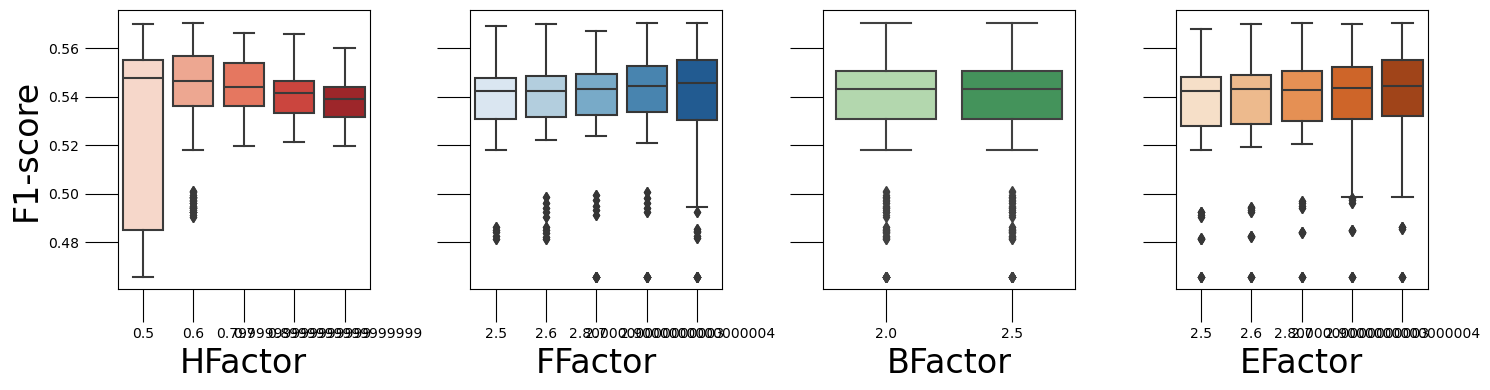

In [40]:
# F1-score
fig, ax = plt.subplots(1,4, figsize=(15,4), sharey=True)

for i, (metric, cmap) in enumerate(zip(['HFactor', 'FFactor', 'BFactor', 'EFactor'], ['Reds','Blues','Greens','Oranges'])):
    
    sns.boxplot(data=results_df, x=metric, y='F1', palette=cmap, ax=ax[i])
    
    ax[i].tick_params(axis='both', size=24)
    ax[i].set_ylabel('', size=24)
    ax[i].set_xlabel(metric, size=24)

ax[0].set_ylabel('F1-score', size=24)
plt.tight_layout()
plt.show()    

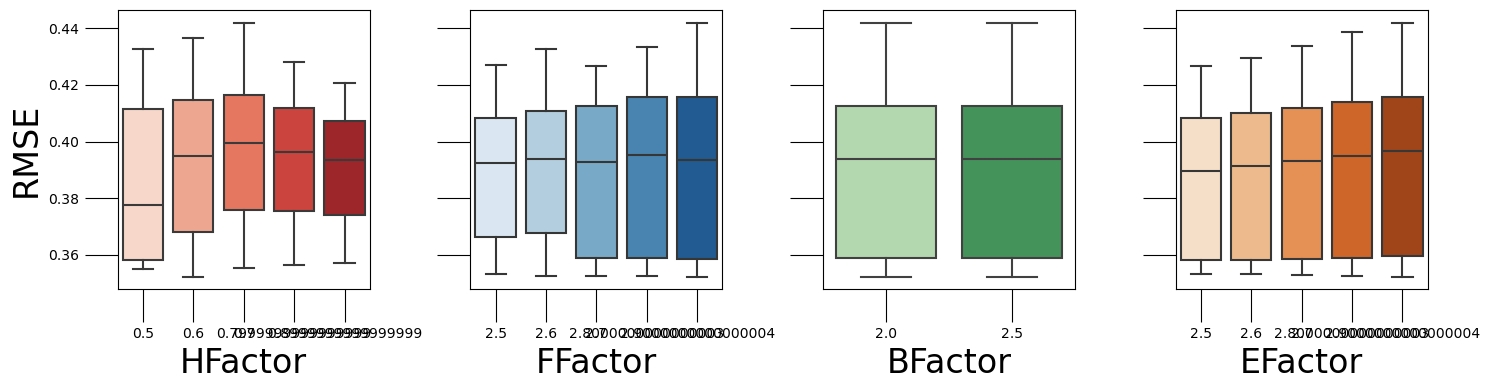

In [41]:
# RMSE
results_df['RMSE'] = np.sqrt(results_df['MSE'])

fig, ax = plt.subplots(1,4, figsize=(15,4), sharey=True)

for i, (metric, cmap) in enumerate(zip(['HFactor', 'FFactor', 'BFactor', 'EFactor'], ['Reds','Blues','Greens','Oranges'])):
    
    sns.boxplot(data=results_df, x=metric, y='RMSE', palette=cmap, ax=ax[i])
    
    ax[i].tick_params(axis='both', size=24)
    ax[i].set_ylabel('', size=24)
    ax[i].set_xlabel(metric, size=24)

ax[0].set_ylabel('RMSE', size=24)
plt.tight_layout()
plt.show()    

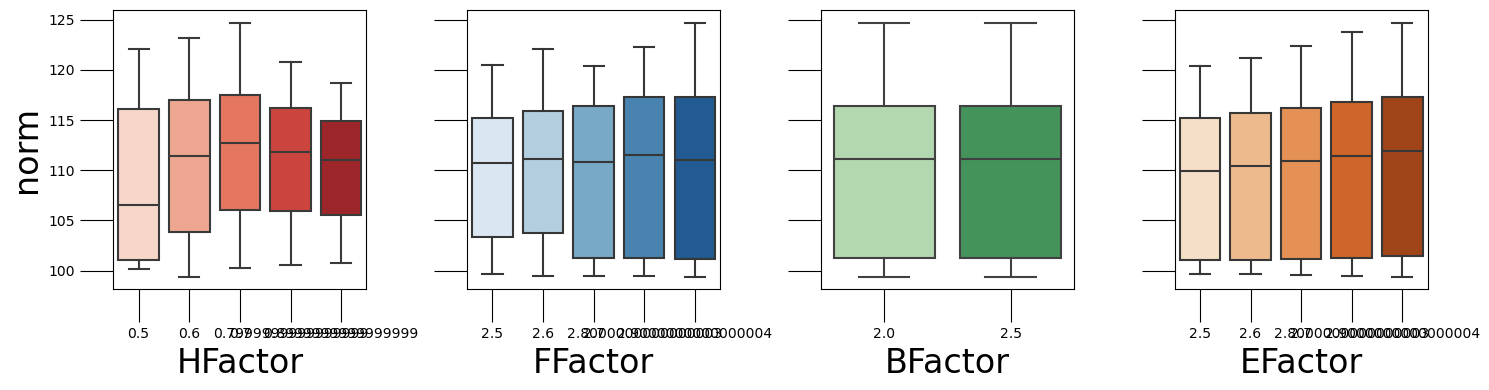

In [42]:
# Norm
fig, ax = plt.subplots(1,4, figsize=(15,4), sharey=True)

for i, (metric, cmap) in enumerate(zip(['HFactor', 'FFactor', 'BFactor', 'EFactor'], ['Reds','Blues','Greens','Oranges'])):
    
    sns.boxplot(data=results_df, x=metric, y='norm', palette=cmap, ax=ax[i])
    
    ax[i].tick_params(axis='both', size=24)
    ax[i].set_ylabel('', size=24)
    ax[i].set_xlabel(metric, size=24)

ax[0].set_ylabel('norm', size=24)
plt.tight_layout()
plt.show()    

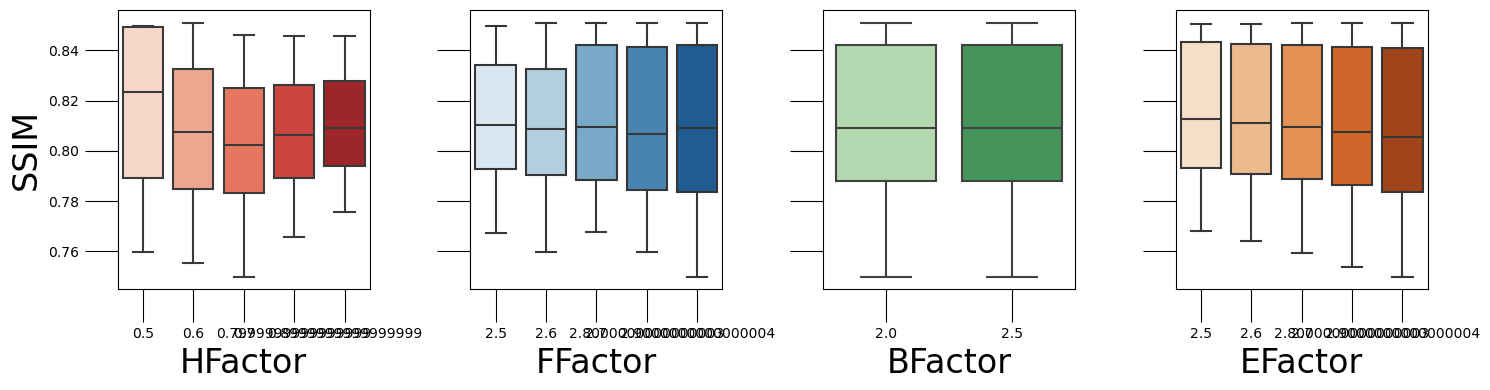

In [43]:
# SSIM
fig, ax = plt.subplots(1,4, figsize=(15,4), sharey=True)

for i, (metric, cmap) in enumerate(zip(['HFactor', 'FFactor', 'BFactor', 'EFactor'], ['Reds','Blues','Greens','Oranges'])):
    
    sns.boxplot(data=results_df, x=metric, y='SSIM', palette=cmap, ax=ax[i])
    
    ax[i].tick_params(axis='both', size=24)
    ax[i].set_ylabel('', size=24)
    ax[i].set_xlabel(metric, size=24)

ax[0].set_ylabel('SSIM', size=24)
plt.tight_layout()
plt.show()    

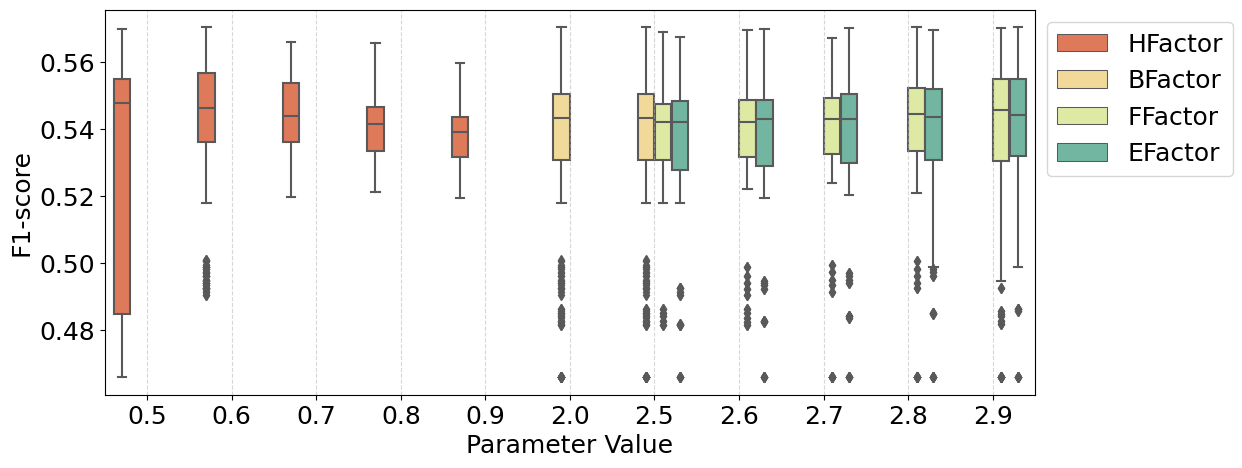

In [44]:
df = results_df[['HFactor', 'BFactor', 'FFactor', 'EFactor', 'F1']]
df.iloc[:, :-1] = df.iloc[:, :-1].round(1)  # Round all columns except 'F1'

fig, ax = plt.subplots(1, figsize=(12,5))

df_melted = df.melt(id_vars="F1", var_name="Factor", value_name="Factor Value")

# Convert to categorical to maintain order
df_melted["Factor Value"] = df_melted["Factor Value"]

sns.boxplot(x="Factor Value", y="F1", hue="Factor", palette='Spectral', data=df_melted, ax=ax)

ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel("Parameter Value", size=18)
ax.set_ylabel("F1-score", size=18)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 18})

# Align grid with categorical x-axis labels
ax.set_xticks(range(len(df_melted["Factor Value"].unique())))
ax.set_xticklabels(sorted(df_melted["Factor Value"].unique()))  # Ensure order
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.show()

In [45]:
results_df.sort_values(by='F1', ascending=False)

,Instance,HFactor,BFactor,FFactor,EFactor,fperiod,ADI,ADI_ue,ADIoe,F1,norm,MSE,area_c2f,SSIM,area_ref,time,RMSE
379,379,0.6,2.5,2.8,2.9,0.4,6.164268,3.322608,2.841660,0.570462,120.664825,0.182889,9074,0.765488,10210,2.937803,0.427656
279,279,0.6,2.0,2.8,2.9,0.4,6.164268,3.322608,2.841660,0.570462,120.664825,0.182889,9074,0.765488,10210,2.811309,0.427656
291,291,0.6,2.0,2.9,2.7,0.4,6.163222,3.306200,2.857022,0.570262,120.884242,0.183555,9145,0.764553,10210,2.569063,0.428433
391,391,0.6,2.5,2.9,2.7,0.4,6.163222,3.306200,2.857022,0.570262,120.884242,0.183555,9145,0.764553,10210,2.621789,0.428433
179,179,0.5,2.5,2.8,2.9,0.4,6.211901,3.370719,2.841182,0.569964,120.461612,0.182274,8973,0.766508,10210,2.320736,0.426935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,176,0.5,2.5,2.8,2.9,0.1,10209.000000,10209.000000,0.000000,0.465842,101.039596,0.128236,1,0.849267,10210,0.574269,0.358101
84,84,0.5,2.0,2.9,2.6,0.1,10209.000000,10209.000000,0.000000,0.465842,101.039596,0.128236,1,0.849267,10210,0.568610,0.358101
80,80,0.5,2.0,2.9,2.5,0.1,10209.000000,10209.000000,0.000000,0.465842,101.039596,0.128236,1,0.849267,10210,0.572803,0.358101
144,144,0.5,2.5,2.7,2.6,0.1,10209.000000,10209.000000,0.000000,0.465842,101.039596,0.128236,1,0.849267,10210,0.887807,0.358101


## 3. Fine-tune with BBO

In [11]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Parameters
INSTANCE = 'canada_dogrib'
N_THREADS = 1
sim = 'C'

# C2F Parameters (tuned)
_HFactor = np.arange(0, 3, 0.5)
_BFactor = np.arange(0, 3, 0.5)
_FFactor = np.arange(0, 3, 0.5)
_EFactor = np.arange(0, 3, 0.5)
_fperiod = np.arange(0, 0.5, 0.1)

print("Number of trials: ", len(_HFactor) * len(_BFactor) * len(_FFactor) * len(_EFactor) * len(_fperiod))

Number of trials:  6480


In [69]:
# Set new instance
INSTANCE = 'dogrib'
out_name = 'dogrib_bbo'

with tqdm.tqdm(total=len(_HFactor) * len(_BFactor) * len(_FFactor) * len(_EFactor) * len(_fperiod), 
        desc="Running...") as pbar:

    # Input instance
    # INSTANCE_PATH = os.path.join(DATA_PATH, INSTANCE)
    INSTANCE_PATH = DATA_PATH

    # Create placeholders
    results = {"Instance":[], "HFactor":[], "BFactor":[], "FFactor":[], "EFactor":[], "fperiod":[],
            "ADI":[], "ADI_ue":[], "ADIoe":[], "F1":[], 
            "norm":[], "MSE":[], "area_c2f":[], "SSIM":[], "area_ref":[], "time":[]
            }
    cnt = 0

    # Load reference dataset (Real scar from Dogrib Fire)
    # /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib/real_scar_dogrib.csv
    df_reference = pd.read_csv(os.path.join(DATA_PATH, 'real_scar_dogrib.csv'), header=None, delimiter=' ')
    df_ref = df_reference.to_numpy().flatten()

    # Loop
    for HFactor in _HFactor:
        for BFactor in _BFactor:
            for FFactor in _FFactor:
                for EFactor in _EFactor:
                    for fperiod in _fperiod:
        
                        OUT_PATH = os.path.join(OUTPUT_PATH, out_name, "sensitivity" + str(cnt))
                        if not os.path.exists(os.path.join(OUTPUT_PATH, out_name)):
                            os.mkdir(os.path.join(OUTPUT_PATH, out_name))     
                        if not os.path.exists(OUT_PATH):
                            os.mkdir(OUT_PATH)

                        # Cell2Fire options
                        args = {
                            'InFolder': INSTANCE_PATH,
                            'OutFolder': OUT_PATH,
                            'ignitions': True,
                            'sim_years': 1,
                            'sim': str(sim),
                            'nsims': 1,
                            'mcnumber': cnt,
                            'Simulator': sim,
                            'grids': False, 
                            'finalGrid': True,
                            'input_PeriodLen': fperiod,
                            'OutMessages': False,
                            'WeatherOpt': 'rows',
                            'nweathers': 1,
                            'ROS_CV': 0.0,
                            'IgRadius': 0, 
                            'seed': 123,
                            'ROS_Threshold':0.0,
                            'HFI_Threshold':0.0,
                            'HFactor':HFactor,
                            'BFactor':BFactor,
                            'FFactor':FFactor,
                            'EFactor':EFactor,
                            'nthreads':N_THREADS,
                            'BBO': True,
                            'HCells': None,
                            'EllipticalOption':1, 
                            'LBFormula':0, 
                            'KOPT':False,
                            'verbose':False
                        }

                        # Convert to object
                        args_obj = Dict2Class(args)
                
                        # Execution
                        start_time = time.time()
                        run(cell2fire_path=CELL2FIRE_PATH, args=args_obj, verbose=True)
                        end_time = time.time()
                        execution_time = end_time - start_time

                        # Load simulated and reference outputs
                        df_result = pd.read_csv(glob.glob(os.path.join(OUT_PATH, 'Grids/Grids1/ForestGrid*.csv'))[0], header=None)
                        df_result_npy = df_result.to_numpy().flatten()

                        # Compute evaluation metrics
                        ADI, ADIue, ADIoe = compute_ADI(df_result, df_ref)
                        # F1, precision, recall = compute_f1_score(df_result, df_farsite)


                        norm = LA.norm(df_result_npy - df_ref)
                        mse = ((df_result_npy - df_ref)**2).mean()
                        F1 = f1_score(df_ref , df_result_npy, average='macro')
                        ssim_sc = ssim(df_result_npy, df_ref, data_range=1)
                        area_cell2fire = len(df_result_npy[df_result_npy == 1])
                        area_ref = len(df_ref[df_ref == 1])

                        results['Instance'].append(cnt)
                        results['HFactor'].append(HFactor)
                        results['BFactor'].append(BFactor)
                        results['FFactor'].append(FFactor)
                        results['EFactor'].append(EFactor)
                        results['fperiod'].append(fperiod)
                        results['ADI'].append(ADI)
                        results['ADI_ue'].append(ADIue)
                        results['ADIoe'].append(ADIoe)
                        results['F1'].append(F1)
                        results['norm'].append(norm)
                        results['MSE'].append(mse)
                        results['SSIM'].append(ssim_sc)
                        results['area_ref'].append(area_ref)
                        results['area_c2f'].append(area_cell2fire)
                        
                        # results['Precision'].append(precision)
                        # results['Recall'].append(recall)
                        results['time'].append(execution_time)                    

                        cnt+=1
                        pbar.update(1)

    # Save  
    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(OUT_PATH, 'all_results_sensitivity_{}.csv'.format(INSTANCE))) # Save to file

Running...:   0%|          | 0/6480 [00:00<?, ?it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity0 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 0 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 1/6480 [00:00<1:11:42,  1.51it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity1 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 1 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 2/6480 [00:01<1:08:21,  1.58it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity2 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 2 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 3/6480 [00:01<1:08:20,  1.58it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity3 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 3 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 4/6480 [00:02<1:06:48,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity4 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 4 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 5/6480 [00:03<1:05:47,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity5 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 5 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 6/6480 [00:03<1:04:56,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity6 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 6 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 7/6480 [00:04<1:05:06,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity7 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 7 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 8/6480 [00:04<1:05:35,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity8 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 8 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 9/6480 [00:05<1:05:59,  1.63it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity9 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 9 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 10/6480 [00:06<1:05:35,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity10 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 10 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 11/6480 [00:06<1:05:30,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity11 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 11 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 12/6480 [00:07<1:05:57,  1.63it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity12 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 12 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 13/6480 [00:08<1:13:25,  1.47it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity13 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 13 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 14/6480 [00:08<1:14:49,  1.44it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity14 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 14 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 15/6480 [00:09<1:24:27,  1.28it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity15 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 15 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 16/6480 [00:10<1:29:18,  1.21it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity16 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 16 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 17/6480 [00:11<1:27:29,  1.23it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity17 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 17 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 18/6480 [00:12<1:32:08,  1.17it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity18 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 18 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 19/6480 [00:13<1:34:15,  1.14it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity19 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 19 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 20/6480 [00:14<1:41:28,  1.06it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity20 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 20 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 21/6480 [00:15<1:38:37,  1.09it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity21 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 21 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 22/6480 [00:16<1:33:35,  1.15it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity22 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 22 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 23/6480 [00:17<1:31:34,  1.18it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity23 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 23 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 24/6480 [00:17<1:25:47,  1.25it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity24 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 24 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 25/6480 [00:18<1:24:06,  1.28it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity25 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 25 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 26/6480 [00:19<1:19:37,  1.35it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity26 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 26 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 27/6480 [00:19<1:16:04,  1.41it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity27 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 27 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 28/6480 [00:20<1:15:53,  1.42it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity28 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 28 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 29/6480 [00:21<1:14:04,  1.45it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity29 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 29 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 30/6480 [00:21<1:13:25,  1.46it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity30 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 30 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 31/6480 [00:22<1:14:33,  1.44it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity31 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 31 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 32/6480 [00:23<1:12:23,  1.48it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity32 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 32 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 33/6480 [00:23<1:14:53,  1.43it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity33 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 33 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 34/6480 [00:24<1:18:52,  1.36it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity34 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 34 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 35/6480 [00:25<1:17:02,  1.39it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity35 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 35 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 36/6480 [00:25<1:14:36,  1.44it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity36 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 36 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 37/6480 [00:26<1:12:00,  1.49it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity37 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 37 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 38/6480 [00:27<1:10:10,  1.53it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity38 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 38 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 39/6480 [00:27<1:08:00,  1.58it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity39 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 39 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 40/6480 [00:28<1:06:07,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity40 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 40 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 41/6480 [00:28<1:05:01,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity41 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 41 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 42/6480 [00:29<1:05:40,  1.63it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity42 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 42 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 43/6480 [00:30<1:08:41,  1.56it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity43 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 43 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 44/6480 [00:30<1:09:40,  1.54it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity44 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 44 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 45/6480 [00:31<1:07:28,  1.59it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity45 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 45 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 46/6480 [00:32<1:05:58,  1.63it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity46 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 46 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 47/6480 [00:32<1:05:04,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity47 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 47 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 48/6480 [00:33<1:06:38,  1.61it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity48 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 48 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 49/6480 [00:34<1:07:25,  1.59it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity49 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 49 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 50/6480 [00:34<1:06:23,  1.61it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity50 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 50 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 51/6480 [00:35<1:13:42,  1.45it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity51 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 51 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 52/6480 [00:36<1:10:44,  1.51it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity52 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 52 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 53/6480 [00:36<1:08:36,  1.56it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity53 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 53 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 54/6480 [00:37<1:10:45,  1.51it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity54 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 54 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 55/6480 [00:37<1:09:13,  1.55it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity55 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 55 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 56/6480 [00:38<1:07:33,  1.58it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity56 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 56 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 57/6480 [00:39<1:06:53,  1.60it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity57 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 57 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 58/6480 [00:39<1:06:31,  1.61it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity58 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 58 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 59/6480 [00:40<1:06:02,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity59 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 59 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 60/6480 [00:40<1:04:50,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity60 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 60 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 61/6480 [00:41<1:04:00,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity61 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 61 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 62/6480 [00:42<1:03:13,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity62 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 62 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 63/6480 [00:42<1:02:42,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity63 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 63 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 64/6480 [00:43<1:02:43,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity64 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 64 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 65/6480 [00:43<1:02:27,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity65 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 65 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 66/6480 [00:44<1:02:19,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity66 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 66 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 67/6480 [00:45<1:02:01,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity67 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 67 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 68/6480 [00:45<1:01:52,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity68 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 68 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 69/6480 [00:46<1:03:04,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity69 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 69 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 70/6480 [00:46<1:02:44,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity70 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 70 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 71/6480 [00:47<1:02:34,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity71 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 71 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 72/6480 [00:47<1:02:13,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity72 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 72 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 73/6480 [00:48<1:02:17,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity73 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 73 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 74/6480 [00:49<1:02:07,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity74 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 74 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 75/6480 [00:49<1:02:00,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity75 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 75 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 76/6480 [00:50<1:07:14,  1.59it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity76 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 76 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 77/6480 [00:51<1:05:25,  1.63it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity77 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 77 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 78/6480 [00:51<1:04:27,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity78 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 78 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 79/6480 [00:52<1:03:47,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity79 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 79 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 80/6480 [00:52<1:02:56,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity80 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 80 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 81/6480 [00:53<1:02:35,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity81 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 81 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 82/6480 [00:53<1:02:10,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity82 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 82 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 83/6480 [00:54<1:02:12,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity83 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 83 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 84/6480 [00:55<1:02:16,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity84 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 84 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 85/6480 [00:55<1:01:57,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity85 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 85 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 86/6480 [00:56<1:02:19,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity86 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 86 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 87/6480 [00:56<1:02:25,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity87 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 87 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 88/6480 [00:57<1:02:40,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity88 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 88 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 89/6480 [00:57<1:02:22,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity89 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 89 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 90/6480 [00:58<1:02:24,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity90 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 90 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 91/6480 [00:59<1:02:19,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity91 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 91 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 92/6480 [00:59<1:02:40,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity92 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 92 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 93/6480 [01:00<1:02:08,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity93 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 93 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 94/6480 [01:00<1:01:52,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity94 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 94 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 95/6480 [01:01<1:01:27,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity95 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 95 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 96/6480 [01:02<1:01:42,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity96 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 96 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 97/6480 [01:02<1:01:24,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity97 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 97 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 98/6480 [01:03<1:01:27,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity98 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 98 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 99/6480 [01:03<1:01:24,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity99 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 99 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 100/6480 [01:04<1:01:20,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity100 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 100 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 101/6480 [01:04<1:01:17,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity101 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 101 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 102/6480 [01:05<1:03:26,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity102 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 102 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 103/6480 [01:06<1:03:25,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity103 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 103 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 104/6480 [01:06<1:02:58,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity104 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 104 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 105/6480 [01:07<1:02:24,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity105 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 105 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 106/6480 [01:07<1:02:06,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity106 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 106 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 107/6480 [01:08<1:02:09,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity107 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 107 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 108/6480 [01:09<1:05:08,  1.63it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity108 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 108 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 109/6480 [01:10<1:14:27,  1.43it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity109 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 109 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 110/6480 [01:10<1:11:46,  1.48it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity110 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 110 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 111/6480 [01:11<1:11:13,  1.49it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity111 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 111 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 112/6480 [01:11<1:09:00,  1.54it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity112 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 112 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 113/6480 [01:12<1:08:26,  1.55it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity113 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 113 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 114/6480 [01:13<1:07:52,  1.56it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity114 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 114 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 115/6480 [01:13<1:08:53,  1.54it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity115 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 115 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 116/6480 [01:14<1:11:49,  1.48it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity116 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 116 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 117/6480 [01:15<1:10:31,  1.50it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity117 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 117 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 118/6480 [01:15<1:08:59,  1.54it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity118 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 118 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 119/6480 [01:16<1:09:41,  1.52it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity119 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 119 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 120/6480 [01:17<1:07:34,  1.57it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity120 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 120 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 121/6480 [01:17<1:05:45,  1.61it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity121 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 121 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 122/6480 [01:18<1:04:44,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity122 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 122 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 123/6480 [01:18<1:04:15,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity123 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 123 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 124/6480 [01:19<1:05:02,  1.63it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity124 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 124 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 125/6480 [01:20<1:04:41,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity125 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 125 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 126/6480 [01:20<1:03:58,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity126 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 126 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 127/6480 [01:21<1:04:51,  1.63it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity127 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 127 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 128/6480 [01:22<1:05:31,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity128 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 128 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 129/6480 [01:22<1:05:57,  1.60it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity129 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 129 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 130/6480 [01:23<1:08:09,  1.55it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity130 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 130 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 131/6480 [01:23<1:07:02,  1.58it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity131 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 131 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 132/6480 [01:24<1:08:54,  1.54it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity132 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 132 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 133/6480 [01:25<1:07:14,  1.57it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity133 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 133 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 134/6480 [01:26<1:13:02,  1.45it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity134 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 134 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 135/6480 [01:26<1:10:11,  1.51it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity135 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 135 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 136/6480 [01:27<1:07:52,  1.56it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity136 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 136 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 137/6480 [01:27<1:10:28,  1.50it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity137 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 137 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 138/6480 [01:28<1:13:23,  1.44it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity138 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 138 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 139/6480 [01:29<1:09:50,  1.51it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity139 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 139 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 140/6480 [01:29<1:07:26,  1.57it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity140 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 140 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 141/6480 [01:30<1:05:32,  1.61it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity141 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 141 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 142/6480 [01:31<1:04:11,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity142 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 142 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 143/6480 [01:31<1:03:10,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity143 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 143 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 144/6480 [01:32<1:02:37,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity144 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 144 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 145/6480 [01:32<1:02:24,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity145 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 145 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 146/6480 [01:33<1:02:08,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity146 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 146 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 147/6480 [01:33<1:01:54,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity147 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 147 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 148/6480 [01:34<1:01:44,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity148 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 148 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 149/6480 [01:35<1:01:38,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity149 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 149 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 150/6480 [01:35<1:01:31,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity150 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 150 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 151/6480 [01:36<1:01:29,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity151 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 151 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 152/6480 [01:36<1:01:46,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity152 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 152 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 153/6480 [01:37<1:01:24,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity153 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 153 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 154/6480 [01:38<1:01:16,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity154 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 154 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 155/6480 [01:38<1:01:13,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity155 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 155 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 156/6480 [01:39<1:00:56,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity156 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 156 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 157/6480 [01:39<1:01:20,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity157 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 157 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 158/6480 [01:40<1:01:29,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity158 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 158 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 159/6480 [01:40<1:01:37,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity159 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 159 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 160/6480 [01:41<1:01:38,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity160 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 160 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 161/6480 [01:42<1:01:14,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity161 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 161 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▎         | 162/6480 [01:42<1:01:35,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity162 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 162 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 163/6480 [01:43<1:01:27,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity163 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 163 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 164/6480 [01:43<1:01:58,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity164 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 164 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 165/6480 [01:44<1:01:54,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity165 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 165 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 166/6480 [01:45<1:01:45,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity166 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 166 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 167/6480 [01:45<1:01:53,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity167 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 167 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 168/6480 [01:46<1:01:48,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity168 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 168 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 169/6480 [01:46<1:01:49,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity169 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 169 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 170/6480 [01:47<1:02:00,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity170 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 170 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 171/6480 [01:48<1:01:52,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity171 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 171 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 172/6480 [01:48<1:01:47,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity172 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 172 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 173/6480 [01:49<1:01:49,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity173 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 173 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 174/6480 [01:49<1:01:45,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity174 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 174 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 175/6480 [01:50<1:01:27,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity175 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 175 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 176/6480 [01:50<1:01:34,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity176 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 176 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 177/6480 [01:51<1:01:40,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity177 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 177 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 178/6480 [01:52<1:01:16,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity178 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 178 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 179/6480 [01:52<1:01:06,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity179 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 179 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 180/6480 [01:53<1:01:00,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity180 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 180 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 181/6480 [01:53<1:00:53,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity181 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 181 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 182/6480 [01:54<1:01:09,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity182 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 182 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 183/6480 [01:55<1:01:15,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity183 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 183 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 184/6480 [01:55<1:01:10,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity184 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 184 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 185/6480 [01:56<1:01:17,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity185 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 185 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 186/6480 [01:56<1:01:27,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity186 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 186 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 187/6480 [01:57<1:01:59,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity187 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 187 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 188/6480 [01:57<1:01:32,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity188 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 188 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 189/6480 [01:58<1:01:25,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity189 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 189 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 190/6480 [01:59<1:01:06,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity190 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 190 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 191/6480 [01:59<1:01:44,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity191 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 191 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 192/6480 [02:00<1:01:17,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity192 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 192 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 193/6480 [02:00<1:01:32,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity193 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 193 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 194/6480 [02:01<1:01:26,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity194 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 194 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 195/6480 [02:02<1:01:03,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity195 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 195 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 196/6480 [02:02<1:00:53,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity196 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 196 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 197/6480 [02:03<1:00:41,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity197 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 197 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 198/6480 [02:03<1:00:20,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity198 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 198 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 199/6480 [02:04<1:00:24,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity199 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 199 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 200/6480 [02:04<1:00:58,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity200 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 200 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 201/6480 [02:05<1:00:44,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity201 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 201 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 202/6480 [02:06<1:00:40,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity202 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 202 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 203/6480 [02:06<1:00:37,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity203 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 203 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 204/6480 [02:07<1:01:46,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity204 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 204 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 205/6480 [02:07<1:01:32,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity205 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 205 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 206/6480 [02:08<1:01:21,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity206 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 206 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 207/6480 [02:09<1:01:06,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity207 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 207 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 208/6480 [02:09<1:03:22,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity208 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 208 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 209/6480 [02:10<1:02:36,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity209 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 209 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 210/6480 [02:10<1:01:49,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity210 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 210 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 211/6480 [02:11<1:01:27,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity211 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 211 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 212/6480 [02:12<1:01:23,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity212 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 212 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 213/6480 [02:12<1:00:56,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity213 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 213 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 214/6480 [02:13<1:01:00,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity214 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 214 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 215/6480 [02:13<1:01:09,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity215 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 215 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 216/6480 [02:14<1:01:11,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity216 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 216 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 217/6480 [02:14<1:01:28,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity217 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 217 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 218/6480 [02:15<1:00:59,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity218 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 218 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 219/6480 [02:16<1:01:00,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity219 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 219 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 220/6480 [02:16<1:00:58,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity220 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 220 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 221/6480 [02:17<1:00:55,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity221 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 221 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 222/6480 [02:17<1:00:43,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity222 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 222 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 223/6480 [02:18<1:00:45,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity223 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 223 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 224/6480 [02:19<1:00:54,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity224 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 224 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 225/6480 [02:19<1:00:44,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity225 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 225 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   3%|▎         | 226/6480 [02:20<1:01:00,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity226 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 226 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▎         | 227/6480 [02:20<1:01:03,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity227 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 227 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▎         | 228/6480 [02:21<1:00:46,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity228 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 228 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▎         | 229/6480 [02:21<1:00:50,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity229 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 229 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▎         | 230/6480 [02:22<1:00:44,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity230 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 230 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▎         | 231/6480 [02:23<1:00:31,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity231 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 231 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▎         | 232/6480 [02:23<1:00:47,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity232 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 232 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▎         | 233/6480 [02:24<1:00:26,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity233 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 233 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▎         | 234/6480 [02:24<1:00:40,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity234 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 234 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▎         | 235/6480 [02:25<1:00:31,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity235 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 235 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▎         | 236/6480 [02:26<1:00:21,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity236 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 236 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▎         | 237/6480 [02:26<1:00:27,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity237 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 237 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▎         | 238/6480 [02:27<1:00:16,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity238 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 238 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▎         | 239/6480 [02:27<1:00:12,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity239 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 239 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▎         | 240/6480 [02:28<1:00:00,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity240 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 240 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▎         | 241/6480 [02:28<1:00:06,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity241 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 241 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▎         | 242/6480 [02:29<1:02:30,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity242 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 242 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 243/6480 [02:30<1:01:59,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity243 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 243 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 244/6480 [02:30<1:01:35,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity244 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 244 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 245/6480 [02:31<1:00:55,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity245 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 245 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 246/6480 [02:31<1:00:46,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity246 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 246 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 247/6480 [02:32<1:00:33,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity247 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 247 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 248/6480 [02:33<1:00:46,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity248 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 248 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 249/6480 [02:33<1:00:30,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity249 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 249 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 250/6480 [02:34<1:00:17,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity250 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 250 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 251/6480 [02:34<1:00:07,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity251 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 251 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 252/6480 [02:35<1:00:14,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity252 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 252 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 253/6480 [02:35<1:00:20,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity253 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 253 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 254/6480 [02:36<1:00:25,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity254 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 254 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 255/6480 [02:37<1:00:26,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity255 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 255 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 256/6480 [02:37<1:00:18,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity256 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 256 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 257/6480 [02:38<1:00:02,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity257 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 257 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 258/6480 [02:38<59:52,  1.73it/s]  

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity258 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 258 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 259/6480 [02:39<1:00:48,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity259 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 259 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 260/6480 [02:40<1:00:31,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity260 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 260 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 261/6480 [02:40<1:00:22,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity261 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 261 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 262/6480 [02:41<1:00:22,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity262 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 262 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 263/6480 [02:41<1:00:09,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity263 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 263 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 264/6480 [02:42<1:00:26,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity264 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 264 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 265/6480 [02:42<1:00:50,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity265 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 265 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 266/6480 [02:43<1:00:26,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity266 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 266 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 267/6480 [02:44<1:00:34,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity267 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 267 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 268/6480 [02:44<1:00:19,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity268 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 268 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 269/6480 [02:45<1:00:15,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity269 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 269 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 270/6480 [02:45<1:00:05,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity270 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 270 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 271/6480 [02:46<59:41,  1.73it/s]  

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity271 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 271 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 272/6480 [02:46<59:49,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity272 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 272 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 273/6480 [02:47<59:55,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity273 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 273 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 274/6480 [02:48<1:01:17,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity274 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 274 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 275/6480 [02:48<1:00:36,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity275 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 275 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 276/6480 [02:49<1:00:25,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity276 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 276 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 277/6480 [02:49<1:00:10,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity277 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 277 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 278/6480 [02:50<1:00:20,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity278 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 278 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 279/6480 [02:51<1:00:23,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity279 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 279 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 280/6480 [02:51<1:00:16,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity280 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 280 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 281/6480 [02:52<1:00:01,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity281 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 281 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 282/6480 [02:52<1:00:04,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity282 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 282 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 283/6480 [02:53<59:51,  1.73it/s]  

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity283 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 283 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 284/6480 [02:53<59:57,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity284 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 284 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 285/6480 [02:54<59:41,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity285 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 285 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 286/6480 [02:55<59:31,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity286 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 286 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 287/6480 [02:55<59:54,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity287 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 287 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 288/6480 [02:56<59:44,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity288 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 288 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 289/6480 [02:56<1:00:23,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity289 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 289 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 290/6480 [02:57<1:00:17,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity290 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 290 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   4%|▍         | 291/6480 [02:58<1:00:00,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity291 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 291 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 292/6480 [02:58<1:00:09,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity292 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 292 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 293/6480 [02:59<1:00:03,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity293 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 293 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 294/6480 [02:59<59:56,  1.72it/s]  

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity294 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 294 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 295/6480 [03:00<59:51,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity295 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 295 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 296/6480 [03:00<59:48,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity296 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 296 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 297/6480 [03:01<59:47,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity297 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 297 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 298/6480 [03:02<59:48,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity298 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 298 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 299/6480 [03:02<59:40,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity299 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 299 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 300/6480 [03:03<59:50,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity300 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 300 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 301/6480 [03:03<59:36,  1.73it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity301 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 301 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 302/6480 [03:04<59:54,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity302 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 302 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 303/6480 [03:05<59:48,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity303 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 303 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 304/6480 [03:05<1:00:03,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity304 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 304 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 305/6480 [03:06<1:02:51,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity305 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 305 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 306/6480 [03:06<1:03:34,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity306 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 306 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 307/6480 [03:07<1:02:57,  1.63it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity307 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 307 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 308/6480 [03:08<1:04:53,  1.59it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity308 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 308 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 309/6480 [03:08<1:04:05,  1.60it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity309 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 309 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 310/6480 [03:09<1:05:44,  1.56it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity310 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 310 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 311/6480 [03:10<1:06:10,  1.55it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity311 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 311 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 312/6480 [03:10<1:06:10,  1.55it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity312 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 312 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 313/6480 [03:11<1:04:45,  1.59it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity313 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 313 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 314/6480 [03:12<1:04:27,  1.59it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity314 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 314 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 315/6480 [03:12<1:04:30,  1.59it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity315 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 315 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 316/6480 [03:13<1:03:15,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity316 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 316 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 317/6480 [03:13<1:02:13,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity317 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 317 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 318/6480 [03:14<1:01:28,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity318 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 318 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 319/6480 [03:14<1:00:52,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity319 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 319 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 320/6480 [03:15<1:00:30,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity320 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 320 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 321/6480 [03:16<1:00:16,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity321 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 321 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 322/6480 [03:16<59:58,  1.71it/s]  

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity322 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 322 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▍         | 323/6480 [03:17<1:00:00,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity323 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 323 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 324/6480 [03:17<1:03:08,  1.63it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity324 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 324 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 325/6480 [03:18<1:02:13,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity325 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 325 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 326/6480 [03:19<1:01:18,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity326 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 326 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 327/6480 [03:19<1:00:42,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity327 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 327 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 328/6480 [03:20<1:00:26,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity328 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 328 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 329/6480 [03:20<1:00:20,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity329 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 329 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 330/6480 [03:21<1:00:21,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity330 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 330 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 331/6480 [03:22<59:53,  1.71it/s]  

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity331 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 331 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 332/6480 [03:22<59:40,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity332 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 332 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 333/6480 [03:23<59:30,  1.72it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity333 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 333 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 334/6480 [03:23<1:00:43,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity334 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 334 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 335/6480 [03:24<1:01:30,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity335 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 335 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 336/6480 [03:25<1:01:06,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity336 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 336 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 337/6480 [03:25<1:01:12,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity337 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 337 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 338/6480 [03:26<1:01:33,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity338 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 338 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 339/6480 [03:26<1:02:17,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity339 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 339 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 340/6480 [03:27<1:01:53,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity340 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 340 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 341/6480 [03:28<1:02:04,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity341 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 341 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 342/6480 [03:28<1:08:21,  1.50it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity342 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 342 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 343/6480 [03:29<1:06:27,  1.54it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity343 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 343 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 344/6480 [03:30<1:04:44,  1.58it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity344 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 344 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 345/6480 [03:30<1:04:07,  1.59it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity345 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 345 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 346/6480 [03:31<1:03:03,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity346 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 346 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 347/6480 [03:31<1:03:41,  1.60it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity347 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 347 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 348/6480 [03:32<1:02:59,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity348 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 348 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 349/6480 [03:33<1:02:17,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity349 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 349 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 350/6480 [03:33<1:01:43,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity350 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 350 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 351/6480 [03:34<1:01:18,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity351 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 351 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 352/6480 [03:34<1:01:06,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity352 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 352 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 353/6480 [03:35<1:01:09,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity353 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 353 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 354/6480 [03:36<1:01:11,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity354 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 354 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 355/6480 [03:36<1:00:50,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity355 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 355 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   5%|▌         | 356/6480 [03:37<1:00:42,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity356 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 356 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 357/6480 [03:37<1:00:27,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity357 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 357 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 358/6480 [03:38<1:00:38,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity358 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 358 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 359/6480 [03:39<1:01:21,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity359 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.5 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 359 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 360/6480 [03:39<1:02:55,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity360 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 360 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 361/6480 [03:40<1:03:03,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity361 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 361 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 362/6480 [03:40<1:02:26,  1.63it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity362 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 362 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 363/6480 [03:41<1:01:45,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity363 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 363 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 364/6480 [03:42<1:01:14,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity364 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 364 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 365/6480 [03:42<1:01:24,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity365 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 365 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 366/6480 [03:43<1:00:53,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity366 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 366 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 367/6480 [03:43<1:01:06,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity367 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 367 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 368/6480 [03:44<1:01:26,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity368 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 368 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 369/6480 [03:45<1:00:59,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity369 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 369 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 370/6480 [03:45<1:00:52,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity370 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 370 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 371/6480 [03:46<1:01:08,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity371 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 371 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 372/6480 [03:46<1:01:22,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity372 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 372 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 373/6480 [03:47<1:02:24,  1.63it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity373 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 373 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 374/6480 [03:48<1:02:56,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity374 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 374 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 375/6480 [03:48<1:02:13,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity375 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 375 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 376/6480 [03:49<1:01:41,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity376 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 376 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 377/6480 [03:49<1:00:58,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity377 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 377 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 378/6480 [03:50<1:00:27,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity378 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 378 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 379/6480 [03:51<1:00:26,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity379 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 379 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 380/6480 [03:51<1:00:33,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity380 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 380 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 381/6480 [03:52<1:00:27,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity381 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 381 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 382/6480 [03:52<1:00:16,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity382 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 382 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 383/6480 [03:53<1:01:15,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity383 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 383 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 384/6480 [03:54<1:01:19,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity384 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 384 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 385/6480 [03:54<1:00:53,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity385 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 385 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 386/6480 [03:55<1:00:53,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity386 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 386 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 387/6480 [03:56<1:02:32,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity387 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 387 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 388/6480 [03:56<1:01:46,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity388 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 388 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 389/6480 [03:57<1:01:18,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity389 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 389 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 390/6480 [03:57<1:00:51,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity390 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 390 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 391/6480 [03:58<1:00:30,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity391 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 391 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 392/6480 [03:58<1:00:46,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity392 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 392 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 393/6480 [03:59<1:01:05,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity393 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 393 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 394/6480 [04:00<1:00:53,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity394 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 394 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 395/6480 [04:00<1:00:33,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity395 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 395 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 396/6480 [04:01<1:00:32,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity396 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 396 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 397/6480 [04:01<1:00:33,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity397 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 397 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 398/6480 [04:02<1:00:16,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity398 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 398 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 399/6480 [04:03<1:00:13,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity399 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 399 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 400/6480 [04:03<1:00:15,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity400 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 400 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 401/6480 [04:04<1:02:21,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity401 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 401 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 402/6480 [04:05<1:01:39,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity402 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 402 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 403/6480 [04:05<1:00:54,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity403 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 403 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▌         | 404/6480 [04:06<1:00:35,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity404 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 404 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▋         | 405/6480 [04:06<1:00:16,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity405 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 405 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▋         | 406/6480 [04:07<1:00:18,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity406 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 406 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▋         | 407/6480 [04:07<1:00:18,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity407 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 407 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▋         | 408/6480 [04:08<1:00:16,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity408 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 408 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▋         | 409/6480 [04:09<1:00:05,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity409 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 409 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▋         | 410/6480 [04:09<1:01:23,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity410 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 410 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▋         | 411/6480 [04:10<1:03:24,  1.60it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity411 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 411 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▋         | 412/6480 [04:11<1:02:18,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity412 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 412 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▋         | 413/6480 [04:11<1:01:33,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity413 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 413 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▋         | 414/6480 [04:12<1:03:57,  1.58it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity414 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 414 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▋         | 415/6480 [04:12<1:02:46,  1.61it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity415 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 415 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▋         | 416/6480 [04:13<1:01:44,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity416 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 416 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▋         | 417/6480 [04:14<1:02:15,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity417 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 417 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▋         | 418/6480 [04:14<1:01:46,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity418 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 418 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▋         | 419/6480 [04:15<1:01:13,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity419 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 419 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▋         | 420/6480 [04:15<1:01:13,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity420 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 420 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   6%|▋         | 421/6480 [04:16<1:00:56,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity421 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 421 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 422/6480 [04:17<1:00:44,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity422 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 422 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 423/6480 [04:17<1:00:31,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity423 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 423 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 424/6480 [04:18<1:00:33,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity424 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 424 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 425/6480 [04:18<1:00:09,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity425 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 425 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 426/6480 [04:19<59:59,  1.68it/s]  

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity426 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 426 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 427/6480 [04:20<1:01:28,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity427 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 427 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 428/6480 [04:20<1:00:59,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity428 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 428 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 429/6480 [04:21<1:00:31,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity429 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 429 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 430/6480 [04:21<1:00:24,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity430 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 430 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 431/6480 [04:22<1:00:49,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity431 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 431 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 432/6480 [04:23<1:00:45,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity432 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 432 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 433/6480 [04:23<1:00:19,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity433 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 433 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 434/6480 [04:24<1:00:13,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity434 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 434 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 435/6480 [04:24<1:00:53,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity435 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 435 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 436/6480 [04:25<1:00:26,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity436 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 436 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 437/6480 [04:26<1:00:17,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity437 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 437 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 438/6480 [04:26<1:00:31,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity438 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 438 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 439/6480 [04:27<1:02:53,  1.60it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity439 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 439 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 440/6480 [04:28<1:02:07,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity440 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 440 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 441/6480 [04:28<1:01:19,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity441 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 441 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 442/6480 [04:29<1:01:14,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity442 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 442 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 443/6480 [04:29<1:00:49,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity443 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 443 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 444/6480 [04:30<1:00:25,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity444 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 444 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 445/6480 [04:31<1:00:15,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity445 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 445 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 446/6480 [04:31<1:00:29,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity446 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 446 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 447/6480 [04:32<1:00:21,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity447 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 447 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 448/6480 [04:32<1:00:05,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity448 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 448 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 449/6480 [04:33<1:00:13,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity449 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 449 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 450/6480 [04:34<1:00:02,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity450 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 450 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 451/6480 [04:34<1:00:14,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity451 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 451 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 452/6480 [04:35<1:01:27,  1.63it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity452 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 452 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 453/6480 [04:35<1:01:08,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity453 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 453 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 454/6480 [04:36<1:01:00,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity454 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 454 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 455/6480 [04:37<1:00:26,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity455 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 455 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 456/6480 [04:37<1:00:12,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity456 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 456 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 457/6480 [04:38<59:49,  1.68it/s]  

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity457 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 457 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 458/6480 [04:38<59:43,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity458 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 458 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 459/6480 [04:39<59:46,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity459 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 459 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 460/6480 [04:40<59:53,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity460 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 460 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 461/6480 [04:40<59:42,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity461 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 461 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 462/6480 [04:41<59:26,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity462 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 462 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 463/6480 [04:41<59:37,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity463 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 463 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 464/6480 [04:42<59:30,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity464 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 464 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 465/6480 [04:42<59:58,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity465 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 465 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 466/6480 [04:43<1:01:08,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity466 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 466 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 467/6480 [04:44<1:01:09,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity467 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 467 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 468/6480 [04:44<1:01:01,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity468 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 468 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 469/6480 [04:45<1:00:40,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity469 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 469 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 470/6480 [04:46<1:00:07,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity470 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 470 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 471/6480 [04:46<59:47,  1.67it/s]  

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity471 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 471 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 472/6480 [04:47<59:42,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity472 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 472 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 473/6480 [04:47<59:37,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity473 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 473 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 474/6480 [04:48<59:40,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity474 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 474 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 475/6480 [04:49<59:46,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity475 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 475 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 476/6480 [04:49<59:20,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity476 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 476 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 477/6480 [04:50<59:22,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity477 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 477 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 478/6480 [04:50<1:00:28,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity478 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 478 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 479/6480 [04:51<1:01:39,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity479 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 479 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 480/6480 [04:52<1:01:17,  1.63it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity480 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 480 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 481/6480 [04:52<1:00:38,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity481 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 481 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 482/6480 [04:53<1:00:12,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity482 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 482 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 483/6480 [04:53<1:00:11,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity483 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 483 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 484/6480 [04:54<59:54,  1.67it/s]  

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity484 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 484 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   7%|▋         | 485/6480 [04:55<59:33,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity485 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 485 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 486/6480 [04:55<59:43,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity486 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 486 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 487/6480 [04:56<59:30,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity487 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 487 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 488/6480 [04:56<59:25,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity488 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 488 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 489/6480 [04:57<59:25,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity489 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 489 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 490/6480 [04:58<59:23,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity490 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 490 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 491/6480 [04:58<59:27,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity491 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 491 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 492/6480 [04:59<1:01:17,  1.63it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity492 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 492 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 493/6480 [04:59<1:01:25,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity493 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 493 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 494/6480 [05:00<1:01:00,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity494 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 494 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 495/6480 [05:01<1:00:55,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity495 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 495 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 496/6480 [05:01<1:00:36,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity496 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 496 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 497/6480 [05:02<59:57,  1.66it/s]  

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity497 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 497 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 498/6480 [05:02<1:00:03,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity498 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 498 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 499/6480 [05:03<59:58,  1.66it/s]  

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity499 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 499 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 500/6480 [05:04<59:46,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity500 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 500 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 501/6480 [05:04<59:24,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity501 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 501 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 502/6480 [05:05<59:15,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity502 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 502 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 503/6480 [05:05<59:15,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity503 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 503 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 504/6480 [05:06<1:01:05,  1.63it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity504 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 504 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 505/6480 [05:07<1:00:44,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity505 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 505 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 506/6480 [05:07<1:00:42,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity506 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 506 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 507/6480 [05:08<1:00:10,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity507 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 507 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 508/6480 [05:08<1:00:17,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity508 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 508 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 509/6480 [05:09<1:00:50,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity509 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 509 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 510/6480 [05:10<1:06:19,  1.50it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity510 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 510 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 511/6480 [05:10<1:04:15,  1.55it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity511 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 511 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 512/6480 [05:11<1:03:08,  1.58it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity512 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 512 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 513/6480 [05:12<1:02:01,  1.60it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity513 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 513 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 514/6480 [05:12<1:01:53,  1.61it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity514 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 514 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 515/6480 [05:13<1:01:39,  1.61it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity515 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 515 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 516/6480 [05:14<1:01:41,  1.61it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity516 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 516 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 517/6480 [05:14<1:05:05,  1.53it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity517 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 517 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 518/6480 [05:15<1:03:40,  1.56it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity518 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 518 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 519/6480 [05:15<1:02:45,  1.58it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity519 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 519 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 520/6480 [05:16<1:01:38,  1.61it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity520 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 520 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 521/6480 [05:17<1:00:38,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity521 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 521 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 522/6480 [05:17<1:00:45,  1.63it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity522 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 522 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 523/6480 [05:18<1:01:25,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity523 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 523 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 524/6480 [05:19<1:02:37,  1.59it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity524 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 524 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 525/6480 [05:19<1:02:21,  1.59it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity525 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 525 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 526/6480 [05:20<1:01:31,  1.61it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity526 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 526 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 527/6480 [05:20<1:01:39,  1.61it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity527 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 527 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 528/6480 [05:21<1:02:22,  1.59it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity528 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 528 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 529/6480 [05:22<1:04:29,  1.54it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity529 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 529 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 530/6480 [05:22<1:04:08,  1.55it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity530 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 530 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 531/6480 [05:23<1:04:18,  1.54it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity531 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 531 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 532/6480 [05:24<1:04:58,  1.53it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity532 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 532 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 533/6480 [05:24<1:06:13,  1.50it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity533 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 533 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 534/6480 [05:25<1:06:56,  1.48it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity534 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 534 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 535/6480 [05:26<1:05:28,  1.51it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity535 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 535 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 536/6480 [05:26<1:05:02,  1.52it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity536 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 536 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 537/6480 [05:27<1:04:00,  1.55it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity537 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 537 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 538/6480 [05:28<1:02:49,  1.58it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity538 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 538 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 539/6480 [05:28<1:02:26,  1.59it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity539 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.0 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 539 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 540/6480 [05:29<1:10:31,  1.40it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity540 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 540 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 541/6480 [05:30<1:09:36,  1.42it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity541 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 541 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 542/6480 [05:30<1:06:36,  1.49it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity542 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 542 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 543/6480 [05:31<1:04:45,  1.53it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity543 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 543 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 544/6480 [05:32<1:06:20,  1.49it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity544 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 544 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 545/6480 [05:32<1:04:46,  1.53it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity545 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 545 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 546/6480 [05:33<1:03:46,  1.55it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity546 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 546 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 547/6480 [05:34<1:06:42,  1.48it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity547 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 547 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 548/6480 [05:34<1:05:16,  1.51it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity548 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 548 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 549/6480 [05:35<1:03:42,  1.55it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity549 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 549 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   8%|▊         | 550/6480 [05:36<1:03:05,  1.57it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity550 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 550 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▊         | 551/6480 [05:36<1:08:30,  1.44it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity551 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 551 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▊         | 552/6480 [05:37<1:07:47,  1.46it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity552 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 552 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▊         | 553/6480 [05:38<1:05:54,  1.50it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity553 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 553 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▊         | 554/6480 [05:38<1:04:48,  1.52it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity554 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 554 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▊         | 555/6480 [05:39<1:04:26,  1.53it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity555 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 555 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▊         | 556/6480 [05:40<1:02:48,  1.57it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity556 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 556 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▊         | 557/6480 [05:40<1:07:54,  1.45it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity557 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 557 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▊         | 558/6480 [05:41<1:09:21,  1.42it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity558 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 558 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▊         | 559/6480 [05:42<1:11:37,  1.38it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity559 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 559 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▊         | 560/6480 [05:43<1:20:12,  1.23it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity560 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 560 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▊         | 561/6480 [05:44<1:16:35,  1.29it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity561 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 561 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▊         | 562/6480 [05:44<1:14:57,  1.32it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity562 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 562 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▊         | 563/6480 [05:45<1:12:30,  1.36it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity563 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 563 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▊         | 564/6480 [05:46<1:10:17,  1.40it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity564 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 564 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▊         | 565/6480 [05:46<1:08:26,  1.44it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity565 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 565 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▊         | 566/6480 [05:47<1:06:16,  1.49it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity566 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 566 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 567/6480 [05:48<1:05:39,  1.50it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity567 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 567 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 568/6480 [05:48<1:07:57,  1.45it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity568 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 568 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 569/6480 [05:49<1:07:41,  1.46it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity569 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 569 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 570/6480 [05:50<1:06:29,  1.48it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity570 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 570 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 571/6480 [05:50<1:06:22,  1.48it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity571 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 571 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 572/6480 [05:51<1:04:43,  1.52it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity572 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 572 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 573/6480 [05:52<1:03:53,  1.54it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity573 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 573 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 574/6480 [05:52<1:03:20,  1.55it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity574 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 574 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 575/6480 [05:53<1:02:49,  1.57it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity575 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 575 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 576/6480 [05:53<1:03:25,  1.55it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity576 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 576 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 577/6480 [05:54<1:02:28,  1.57it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity577 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 577 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 578/6480 [05:55<1:02:20,  1.58it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity578 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 578 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 579/6480 [05:55<1:00:59,  1.61it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity579 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 579 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 580/6480 [05:56<1:00:43,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity580 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 580 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 581/6480 [05:57<1:00:03,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity581 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 581 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 582/6480 [05:57<59:31,  1.65it/s]  

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity582 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 582 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 583/6480 [05:58<58:57,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity583 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 583 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 584/6480 [05:58<58:37,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity584 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 584 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 585/6480 [05:59<58:28,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity585 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 585 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 586/6480 [06:00<59:43,  1.64it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity586 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 586 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 587/6480 [06:01<1:13:17,  1.34it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity587 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 587 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 588/6480 [06:02<1:18:45,  1.25it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity588 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 588 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 589/6480 [06:02<1:15:57,  1.29it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity589 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 589 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 590/6480 [06:03<1:12:17,  1.36it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity590 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 590 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 591/6480 [06:03<1:08:04,  1.44it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity591 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 591 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 592/6480 [06:04<1:05:09,  1.51it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity592 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 592 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 593/6480 [06:05<1:02:56,  1.56it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity593 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 593 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 594/6480 [06:05<1:01:49,  1.59it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity594 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 594 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 595/6480 [06:06<1:01:39,  1.59it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity595 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 595 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 596/6480 [06:06<1:00:34,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity596 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 596 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 597/6480 [06:07<59:24,  1.65it/s]  

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity597 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 597 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 598/6480 [06:08<59:09,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity598 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 598 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 599/6480 [06:08<59:03,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity599 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 599 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 600/6480 [06:09<58:42,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity600 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 600 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 601/6480 [06:09<1:00:29,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity601 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 601 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 602/6480 [06:10<1:03:24,  1.54it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity602 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 602 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 603/6480 [06:11<1:02:37,  1.56it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity603 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 603 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 604/6480 [06:11<1:02:22,  1.57it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity604 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 604 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 605/6480 [06:12<1:03:03,  1.55it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity605 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 605 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 606/6480 [06:13<1:02:10,  1.57it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity606 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 606 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 607/6480 [06:13<1:03:37,  1.54it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity607 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 607 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 608/6480 [06:14<1:02:28,  1.57it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity608 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 608 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 609/6480 [06:15<1:00:53,  1.61it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity609 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 609 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 610/6480 [06:15<59:49,  1.64it/s]  

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity610 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 610 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 611/6480 [06:16<58:58,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity611 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 611 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 612/6480 [06:16<59:02,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity612 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 612 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 613/6480 [06:17<58:30,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity613 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 613 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 614/6480 [06:18<58:54,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity614 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 614 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   9%|▉         | 615/6480 [06:18<58:43,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity615 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 615 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 616/6480 [06:19<58:13,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity616 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 616 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 617/6480 [06:19<57:59,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity617 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 617 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 618/6480 [06:20<57:52,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity618 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 618 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 619/6480 [06:21<57:36,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity619 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 619 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 620/6480 [06:21<57:30,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity620 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 620 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 621/6480 [06:22<57:21,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity621 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 621 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 622/6480 [06:22<57:08,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity622 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 622 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 623/6480 [06:23<57:52,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity623 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 623 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 624/6480 [06:23<57:34,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity624 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 624 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 625/6480 [06:24<57:27,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity625 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 625 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 626/6480 [06:25<57:21,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity626 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 626 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 627/6480 [06:25<57:26,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity627 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 627 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 628/6480 [06:26<58:23,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity628 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 628 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 629/6480 [06:26<58:09,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity629 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 629 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 630/6480 [06:27<58:19,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity630 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 630 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 631/6480 [06:28<57:47,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity631 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 631 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 632/6480 [06:28<57:22,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity632 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 632 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 633/6480 [06:29<57:09,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity633 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 633 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 634/6480 [06:29<57:20,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity634 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 634 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 635/6480 [06:30<57:18,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity635 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 635 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 636/6480 [06:31<1:01:02,  1.60it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity636 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 636 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 637/6480 [06:31<1:00:40,  1.60it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity637 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 637 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 638/6480 [06:32<59:35,  1.63it/s]  

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity638 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 638 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 639/6480 [06:32<58:52,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity639 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 639 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 640/6480 [06:33<58:19,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity640 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 640 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 641/6480 [06:34<57:54,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity641 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 641 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 642/6480 [06:34<57:35,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity642 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 642 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 643/6480 [06:35<57:30,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity643 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 643 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 644/6480 [06:35<57:24,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity644 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 1.0 --bbo --mcnumber 644 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 645/6480 [06:36<57:20,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity645 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 645 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 646/6480 [06:37<57:08,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity646 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 646 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|▉         | 647/6480 [06:37<57:13,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity647 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 647 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 648/6480 [06:38<57:08,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity648 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 648 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 649/6480 [06:38<57:05,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity649 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 1.5 --bbo --mcnumber 649 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 650/6480 [06:39<57:17,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity650 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 650 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 651/6480 [06:40<57:09,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity651 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 651 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 652/6480 [06:40<57:12,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity652 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 652 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 653/6480 [06:41<57:27,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity653 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 653 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 654/6480 [06:41<57:32,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity654 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 2.0 --bbo --mcnumber 654 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 655/6480 [06:42<57:44,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity655 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 655 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 656/6480 [06:43<57:42,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity656 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 656 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 657/6480 [06:43<57:38,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity657 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 657 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 658/6480 [06:44<57:32,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity658 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 658 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 659/6480 [06:44<57:55,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity659 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 1.5 --EFactor 2.5 --bbo --mcnumber 659 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 660/6480 [06:45<57:50,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity660 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 660 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 661/6480 [06:45<57:42,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity661 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 661 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 662/6480 [06:46<57:32,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity662 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 662 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 663/6480 [06:47<57:18,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity663 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 663 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 664/6480 [06:47<57:21,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity664 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 0.0 --bbo --mcnumber 664 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 665/6480 [06:48<57:02,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity665 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 665 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 666/6480 [06:48<57:14,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity666 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 666 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 667/6480 [06:49<57:32,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity667 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 667 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 668/6480 [06:50<57:36,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity668 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 668 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 669/6480 [06:50<57:41,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity669 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 0.5 --bbo --mcnumber 669 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 670/6480 [06:51<57:56,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity670 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 670 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 671/6480 [06:51<57:29,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity671 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 671 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 672/6480 [06:52<57:21,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity672 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 672 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 673/6480 [06:53<58:30,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity673 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 673 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 674/6480 [06:53<58:04,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity674 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 1.0 --bbo --mcnumber 674 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 675/6480 [06:54<57:37,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity675 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 675 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 676/6480 [06:54<57:25,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity676 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 676 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 677/6480 [06:55<57:11,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity677 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 677 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 678/6480 [06:56<56:58,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity678 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 678 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 679/6480 [06:56<56:58,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity679 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 1.5 --bbo --mcnumber 679 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  10%|█         | 680/6480 [06:57<57:04,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity680 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 680 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 681/6480 [06:57<57:15,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity681 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 681 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 682/6480 [06:58<57:08,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity682 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 682 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 683/6480 [06:59<57:08,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity683 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 683 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 684/6480 [06:59<57:08,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity684 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 2.0 --bbo --mcnumber 684 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 685/6480 [07:00<56:50,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity685 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 685 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 686/6480 [07:00<56:39,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity686 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 686 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 687/6480 [07:01<56:34,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity687 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 687 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 688/6480 [07:01<56:41,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity688 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 688 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 689/6480 [07:02<56:47,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity689 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.0 --EFactor 2.5 --bbo --mcnumber 689 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 690/6480 [07:03<56:44,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity690 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 690 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 691/6480 [07:03<57:11,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity691 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 691 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 692/6480 [07:04<56:47,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity692 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 692 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 693/6480 [07:04<56:40,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity693 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 693 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 694/6480 [07:05<56:37,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity694 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 0.0 --bbo --mcnumber 694 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 695/6480 [07:06<56:29,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity695 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 695 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 696/6480 [07:06<56:21,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity696 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 696 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 697/6480 [07:07<56:27,  1.71it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity697 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 697 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 698/6480 [07:07<56:42,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity698 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 698 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 699/6480 [07:08<57:08,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity699 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 0.5 --bbo --mcnumber 699 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 700/6480 [07:09<56:57,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity700 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 700 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 701/6480 [07:09<56:53,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity701 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 701 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 702/6480 [07:10<59:06,  1.63it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity702 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 702 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 703/6480 [07:10<58:23,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity703 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 703 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 704/6480 [07:11<57:50,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity704 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 1.0 --bbo --mcnumber 704 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 705/6480 [07:12<57:30,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity705 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 705 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 706/6480 [07:12<57:07,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity706 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 706 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 707/6480 [07:13<56:49,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity707 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 707 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 708/6480 [07:13<56:56,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity708 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 708 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 709/6480 [07:14<57:33,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity709 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 1.5 --bbo --mcnumber 709 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 710/6480 [07:15<57:15,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity710 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 710 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 711/6480 [07:15<57:01,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity711 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 711 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 712/6480 [07:16<59:22,  1.62it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity712 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 712 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 713/6480 [07:16<1:01:14,  1.57it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity713 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 713 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 714/6480 [07:17<1:00:22,  1.59it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity714 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 2.0 --bbo --mcnumber 714 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 715/6480 [07:18<59:43,  1.61it/s]  

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity715 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 715 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 716/6480 [07:18<58:49,  1.63it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity716 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 716 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 717/6480 [07:19<58:04,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity717 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 717 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 718/6480 [07:19<57:32,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity718 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 718 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 719/6480 [07:20<57:31,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity719 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 1.5 --FFactor 2.5 --EFactor 2.5 --bbo --mcnumber 719 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 720/6480 [07:21<57:29,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity720 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 720 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 721/6480 [07:21<57:13,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity721 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 721 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 722/6480 [07:22<56:55,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity722 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 722 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 723/6480 [07:22<56:56,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity723 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 723 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 724/6480 [07:23<57:09,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity724 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 724 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 725/6480 [07:24<56:52,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity725 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 725 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 726/6480 [07:24<56:55,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity726 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 726 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 727/6480 [07:25<56:49,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity727 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 727 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█         | 728/6480 [07:25<56:41,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity728 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 728 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█▏        | 729/6480 [07:26<56:46,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity729 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 729 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█▏        | 730/6480 [07:27<57:02,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity730 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 730 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█▏        | 731/6480 [07:27<56:49,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity731 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 731 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█▏        | 732/6480 [07:28<56:39,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity732 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 732 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█▏        | 733/6480 [07:28<56:25,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity733 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 733 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█▏        | 734/6480 [07:29<56:35,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity734 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 734 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█▏        | 735/6480 [07:30<56:29,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity735 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 735 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█▏        | 736/6480 [07:30<56:21,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity736 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 736 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█▏        | 737/6480 [07:31<56:13,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity737 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 737 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█▏        | 738/6480 [07:31<56:40,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity738 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 738 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█▏        | 739/6480 [07:32<56:34,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity739 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 739 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█▏        | 740/6480 [07:32<56:43,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity740 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 740 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█▏        | 741/6480 [07:33<57:03,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity741 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 741 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█▏        | 742/6480 [07:34<56:56,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity742 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 742 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█▏        | 743/6480 [07:34<56:41,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity743 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 743 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█▏        | 744/6480 [07:35<56:50,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity744 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 744 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  11%|█▏        | 745/6480 [07:35<56:47,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity745 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 745 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 746/6480 [07:36<56:36,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity746 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 746 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 747/6480 [07:37<56:27,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity747 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 747 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 748/6480 [07:37<56:12,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity748 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 748 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 749/6480 [07:38<57:36,  1.66it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity749 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 749 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 750/6480 [07:38<57:02,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity750 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 750 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 751/6480 [07:39<57:02,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity751 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 751 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 752/6480 [07:40<56:58,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity752 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 752 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 753/6480 [07:40<56:32,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity753 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 753 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 754/6480 [07:41<56:19,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity754 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 754 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 755/6480 [07:41<56:10,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity755 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 755 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 756/6480 [07:42<57:45,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity756 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 756 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 757/6480 [07:43<57:11,  1.67it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity757 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 757 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 758/6480 [07:43<56:36,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity758 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 758 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 759/6480 [07:44<56:21,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity759 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 759 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 760/6480 [07:44<56:06,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity760 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 760 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 761/6480 [07:45<56:08,  1.70it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity761 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 761 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 762/6480 [07:46<56:23,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity762 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 762 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 763/6480 [07:46<56:28,  1.69it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity763 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 763 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 764/6480 [07:47<56:33,  1.68it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity764 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 764 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 765/6480 [07:47<57:33,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity765 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 765 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 766/6480 [07:48<57:50,  1.65it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity766 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 766 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 767/6480 [07:49<1:01:06,  1.56it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity767 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 767 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 768/6480 [07:49<1:01:12,  1.56it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity768 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 768 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 769/6480 [07:50<1:02:49,  1.51it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity769 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 769 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 770/6480 [07:51<1:03:09,  1.51it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity770 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 770 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 771/6480 [07:52<1:06:45,  1.43it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity771 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 771 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 772/6480 [07:52<1:06:14,  1.44it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity772 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 772 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 773/6480 [07:53<1:06:55,  1.42it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity773 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 773 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 774/6480 [07:54<1:10:44,  1.34it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity774 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 774 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 775/6480 [07:55<1:11:45,  1.33it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity775 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 775 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 776/6480 [07:55<1:10:21,  1.35it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity776 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.1  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 776 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 777/6480 [07:56<1:10:41,  1.34it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity777 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.2  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 777 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 778/6480 [07:57<1:11:27,  1.33it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity778 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.30000000000000004  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 778 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 779/6480 [07:57<1:07:37,  1.41it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity779 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.4  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 779 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 780/6480 [07:58<1:04:44,  1.47it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity780 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 2.0 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 780 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:  12%|█▏        | 780/6480 [07:58<58:18,  1.63it/s]  


KeyboardInterrupt: 

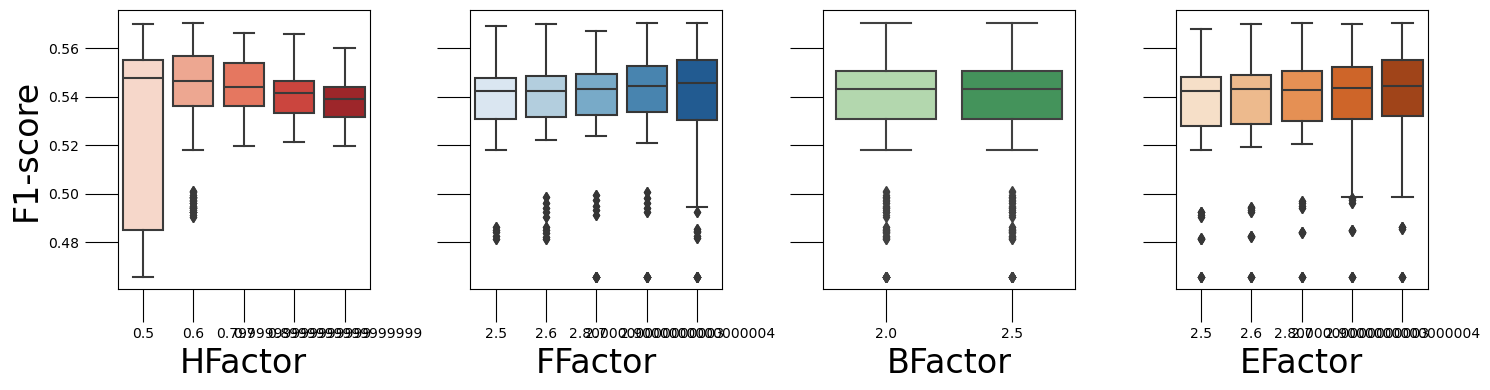

In [ ]:
# F1-score
fig, ax = plt.subplots(1,4, figsize=(15,4), sharey=True)

for i, (metric, cmap) in enumerate(zip(['HFactor', 'FFactor', 'BFactor', 'EFactor'], ['Reds','Blues','Greens','Oranges'])):
    
    sns.boxplot(data=results_df, x=metric, y='F1', palette=cmap, ax=ax[i])
    
    ax[i].tick_params(axis='both', size=24)
    ax[i].set_ylabel('', size=24)
    ax[i].set_xlabel(metric, size=24)

ax[0].set_ylabel('F1-score', size=24)
plt.tight_layout()
plt.show()    

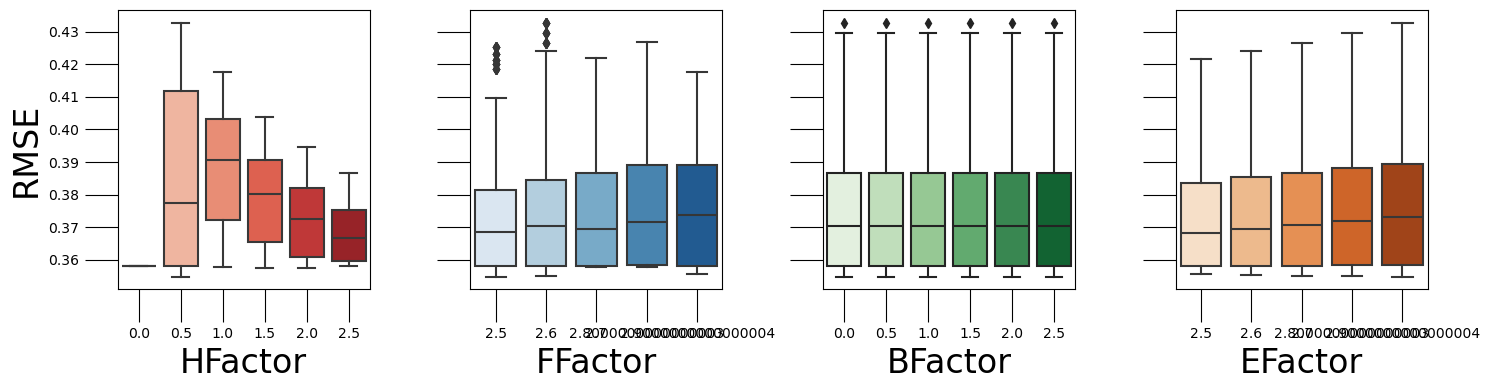

In [ ]:
# RMSE
results_df['RMSE'] = np.sqrt(results_df['MSE'])

fig, ax = plt.subplots(1,4, figsize=(15,4), sharey=True)

for i, (metric, cmap) in enumerate(zip(['HFactor', 'FFactor', 'BFactor', 'EFactor'], ['Reds','Blues','Greens','Oranges'])):
    
    sns.boxplot(data=results_df, x=metric, y='RMSE', palette=cmap, ax=ax[i])
    
    ax[i].tick_params(axis='both', size=24)
    ax[i].set_ylabel('', size=24)
    ax[i].set_xlabel(metric, size=24)

ax[0].set_ylabel('RMSE', size=24)
plt.tight_layout()
plt.show()    

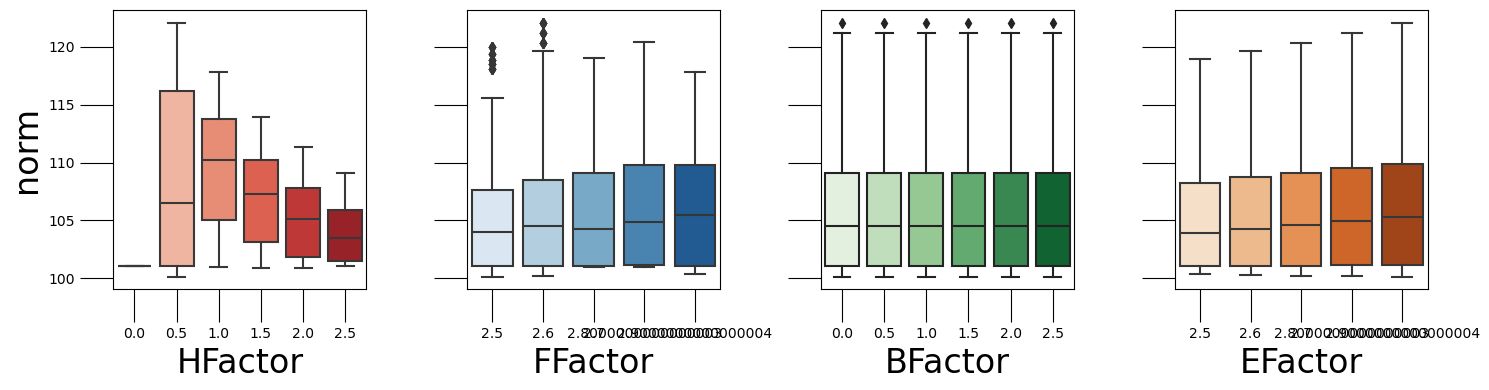

In [ ]:
# Norm
fig, ax = plt.subplots(1,4, figsize=(15,4), sharey=True)

for i, (metric, cmap) in enumerate(zip(['HFactor', 'FFactor', 'BFactor', 'EFactor'], ['Reds','Blues','Greens','Oranges'])):
    
    sns.boxplot(data=results_df, x=metric, y='norm', palette=cmap, ax=ax[i])
    
    ax[i].tick_params(axis='both', size=24)
    ax[i].set_ylabel('', size=24)
    ax[i].set_xlabel(metric, size=24)

ax[0].set_ylabel('norm', size=24)
plt.tight_layout()
plt.show()    

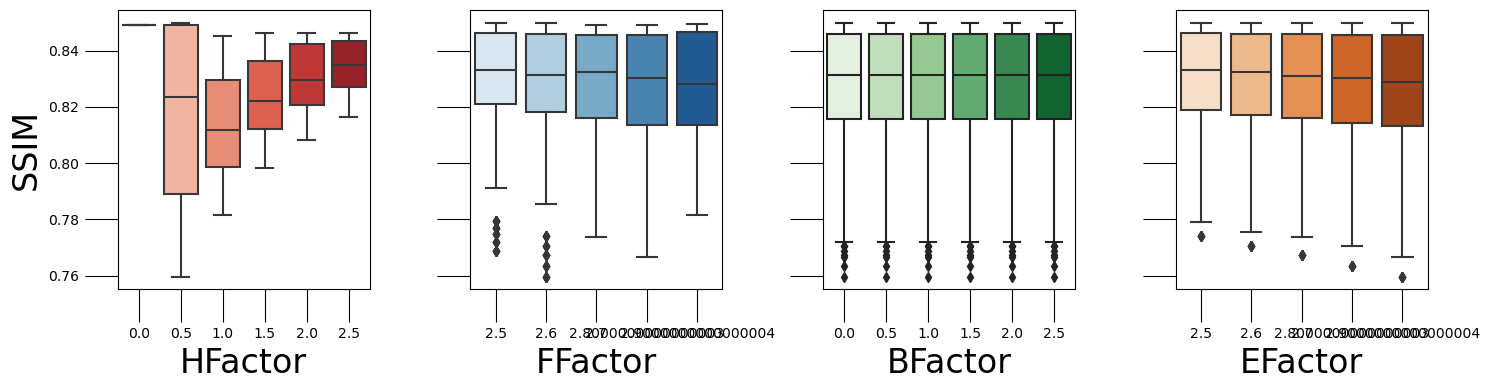

In [ ]:
# SSIM
fig, ax = plt.subplots(1,4, figsize=(15,4), sharey=True)

for i, (metric, cmap) in enumerate(zip(['HFactor', 'FFactor', 'BFactor', 'EFactor'], ['Reds','Blues','Greens','Oranges'])):
    
    sns.boxplot(data=results_df, x=metric, y='SSIM', palette=cmap, ax=ax[i])
    
    ax[i].tick_params(axis='both', size=24)
    ax[i].set_ylabel('', size=24)
    ax[i].set_xlabel(metric, size=24)

ax[0].set_ylabel('SSIM', size=24)
plt.tight_layout()
plt.show()    

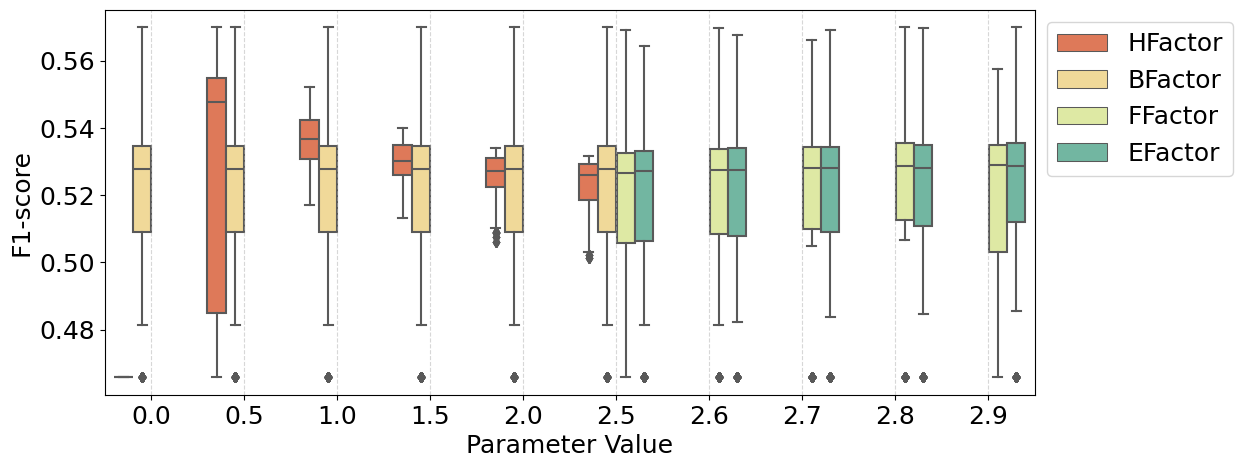

In [ ]:
df = results_df[['HFactor', 'BFactor', 'FFactor', 'EFactor', 'F1']]
df.iloc[:, :-1] = df.iloc[:, :-1].round(1)  # Round all columns except 'F1'

fig, ax = plt.subplots(1, figsize=(12,5))

df_melted = df.melt(id_vars="F1", var_name="Factor", value_name="Factor Value")

# Convert to categorical to maintain order
df_melted["Factor Value"] = df_melted["Factor Value"]

sns.boxplot(x="Factor Value", y="F1", hue="Factor", palette='Spectral', data=df_melted, ax=ax)

ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel("Parameter Value", size=18)
ax.set_ylabel("F1-score", size=18)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 18})

# Align grid with categorical x-axis labels
ax.set_xticks(range(len(df_melted["Factor Value"].unique())))
ax.set_xticklabels(sorted(df_melted["Factor Value"].unique()))  # Ensure order
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.show()

In [ ]:
results_df.sort_values(by='F1', ascending=False)

,Instance,HFactor,BFactor,FFactor,EFactor,fperiod,ADI,ADI_ue,ADIoe,F1,norm,MSE,area_c2f,SSIM,area_ref,time,RMSE
979,979,0.5,1.5,2.8,2.9,0.4,6.211901,3.370719,2.841182,0.569964,120.461612,0.182274,8973,0.766508,10210,2.144572,0.426935
879,879,0.5,1.0,2.8,2.9,0.4,6.211901,3.370719,2.841182,0.569964,120.461612,0.182274,8973,0.766508,10210,2.015767,0.426935
679,679,0.5,0.0,2.8,2.9,0.4,6.211901,3.370719,2.841182,0.569964,120.461612,0.182274,8973,0.766508,10210,2.082313,0.426935
779,779,0.5,0.5,2.8,2.9,0.4,6.211901,3.370719,2.841182,0.569964,120.461612,0.182274,8973,0.766508,10210,2.292135,0.426935
1079,1079,0.5,2.0,2.8,2.9,0.4,6.211901,3.370719,2.841182,0.569964,120.461612,0.182274,8973,0.766508,10210,2.021726,0.426935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,427,0.0,2.0,2.6,2.6,0.4,10209.000000,10209.000000,0.000000,0.465842,101.039596,0.128236,1,0.849267,10210,0.545427,0.358101
426,426,0.0,2.0,2.6,2.6,0.3,10209.000000,10209.000000,0.000000,0.465842,101.039596,0.128236,1,0.849267,10210,0.550806,0.358101
425,425,0.0,2.0,2.6,2.6,0.2,10209.000000,10209.000000,0.000000,0.465842,101.039596,0.128236,1,0.849267,10210,0.545625,0.358101
424,424,0.0,2.0,2.6,2.6,0.1,10209.000000,10209.000000,0.000000,0.465842,101.039596,0.128236,1,0.849267,10210,0.546384,0.358101


## 3. Fine-tune with optmized hyperparameters

In [ ]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Parameters
INSTANCE = 'canada_dogrib'
N_THREADS = 1
sim = 'C'

# C2F Parameters (tuned)
_HFactor = np.arange(0, 3, 0.5)
_BFactor = np.arange(0, 3, 0.5)
_FFactor = np.arange(0, 3, 0.5)
_EFactor = np.arange(0, 3, 0.5)
_fperiod = np.arange(0, 2, 0.5)

print("Number of trials: ", len(_HFactor) * len(_BFactor) * len(_FFactor) * len(_EFactor) * len(_fperiod))

Number of trials:  5184


In [ ]:
# Set new instance
INSTANCE = 'dogrib'
out_name = 'dogrib_bbo_finetuned'

with tqdm.tqdm(total=len(_HFactor) * len(_BFactor) * len(_FFactor) * len(_EFactor) * len(_fperiod), 
        desc="Running...") as pbar:

    # Input instance
    # INSTANCE_PATH = os.path.join(DATA_PATH, INSTANCE)
    INSTANCE_PATH = DATA_PATH

    # Create placeholders
    results = {"Instance":[], "HFactor":[], "BFactor":[], "FFactor":[], "EFactor":[], "fperiod":[],
            "ADI":[], "ADI_ue":[], "ADIoe":[], "F1":[], 
            "norm":[], "MSE":[], "area_c2f":[], "SSIM":[], "area_ref":[], "time":[]
            }
    cnt = 0

    # Load reference dataset (Real scar from Dogrib Fire)
    # /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib/real_scar_dogrib.csv
    df_reference = pd.read_csv(os.path.join(DATA_PATH, 'real_scar_dogrib.csv'), header=None, delimiter=' ')
    df_ref = df_reference.to_numpy().flatten()

    # Loop
    for HFactor in _HFactor:
        for BFactor in _BFactor:
            for FFactor in _FFactor:
                for EFactor in _EFactor:
                    for fperiod in _fperiod:
        
                        OUT_PATH = os.path.join(OUTPUT_PATH, out_name, "sensitivity" + str(cnt))
                        if not os.path.exists(os.path.join(OUTPUT_PATH, out_name)):
                            os.mkdir(os.path.join(OUTPUT_PATH, out_name))     
                        if not os.path.exists(OUT_PATH):
                            os.mkdir(OUT_PATH)

                        # Cell2Fire options
                        args = {
                            'InFolder': INSTANCE_PATH,
                            'OutFolder': OUT_PATH,
                            'ignitions': True,
                            'sim_years': 1,
                            'sim': str(sim),
                            'nsims': 1,
                            'mcnumber': cnt,
                            'Simulator': sim,
                            'grids': False, 
                            'finalGrid': True,
                            'input_PeriodLen': fperiod,
                            'OutMessages': False,
                            'WeatherOpt': 'rows',
                            'nweathers': 1,
                            'ROS_CV': 0.0,
                            'IgRadius': 0, 
                            'seed': 123,
                            'ROS_Threshold':0.0,
                            'HFI_Threshold':0.0,
                            'HFactor':HFactor,
                            'BFactor':BFactor,
                            'FFactor':FFactor,
                            'EFactor':EFactor,
                            'nthreads':N_THREADS,
                            'BBO': True,
                            'HCells': None,
                            'EllipticalOption':1, 
                            'LBFormula':0, 
                            'KOPT':False,
                            'verbose':False
                        }

                        # Convert to object
                        args_obj = Dict2Class(args)
                
                        # Execution
                        start_time = time.time()
                        run(cell2fire_path=CELL2FIRE_PATH, args=args_obj, verbose=True)
                        end_time = time.time()
                        execution_time = end_time - start_time

                        # Load simulated and reference outputs
                        df_result = pd.read_csv(glob.glob(os.path.join(OUT_PATH, 'Grids/Grids1/ForestGrid*.csv'))[0], header=None)
                        df_result_npy = df_result.to_numpy().flatten()

                        # Compute evaluation metrics
                        ADI, ADIue, ADIoe = compute_ADI(df_result, df_ref)
                        # F1, precision, recall = compute_f1_score(df_result, df_farsite)


                        norm = LA.norm(df_result_npy - df_ref)
                        mse = ((df_result_npy - df_ref)**2).mean()
                        F1 = f1_score(df_ref , df_result_npy, average='macro')
                        ssim_sc = ssim(df_result_npy, df_ref, data_range=1)
                        area_cell2fire = len(df_result_npy[df_result_npy == 1])
                        area_ref = len(df_ref[df_ref == 1])

                        results['Instance'].append(cnt)
                        results['HFactor'].append(HFactor)
                        results['BFactor'].append(BFactor)
                        results['FFactor'].append(FFactor)
                        results['EFactor'].append(EFactor)
                        results['fperiod'].append(fperiod)
                        results['ADI'].append(ADI)
                        results['ADI_ue'].append(ADIue)
                        results['ADIoe'].append(ADIoe)
                        results['F1'].append(F1)
                        results['norm'].append(norm)
                        results['MSE'].append(mse)
                        results['SSIM'].append(ssim_sc)
                        results['area_ref'].append(area_ref)
                        results['area_c2f'].append(area_cell2fire)
                        
                        # results['Precision'].append(precision)
                        # results['Recall'].append(recall)
                        results['time'].append(execution_time)                    

                        cnt+=1
                        pbar.update(1)

    # Save  
    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(OUT_PATH, 'all_results_sensitivity_{}.csv'.format(INSTANCE))) # Save to file

Running...:   0%|          | 0/5184 [00:00<?, ?it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity0 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 0 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 1/5184 [00:01<1:49:26,  1.27s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity1 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 1 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 2/5184 [00:02<1:38:00,  1.13s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity2 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 2 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 3/5184 [00:03<1:33:23,  1.08s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity3 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 0.0 --bbo --mcnumber 3 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 4/5184 [00:04<1:39:38,  1.15s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity4 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 4 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 5/5184 [00:05<1:32:28,  1.07s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity5 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 5 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 6/5184 [00:06<1:28:47,  1.03s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity6 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 6 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 7/5184 [00:07<1:27:07,  1.01s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity7 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 0.5 --bbo --mcnumber 7 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 8/5184 [00:08<1:26:15,  1.00it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity8 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 8 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 9/5184 [00:09<1:30:54,  1.05s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity9 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 9 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 10/5184 [00:10<1:27:23,  1.01s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity10 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 10 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 11/5184 [00:11<1:25:03,  1.01it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity11 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 1.0 --bbo --mcnumber 11 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 12/5184 [00:12<1:25:16,  1.01it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity12 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 12 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 13/5184 [00:13<1:23:58,  1.03it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity13 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 13 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 14/5184 [00:14<1:22:23,  1.05it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity14 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 14 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 15/5184 [00:15<1:21:08,  1.06it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity15 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 1.5 --bbo --mcnumber 15 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 16/5184 [00:16<1:20:51,  1.07it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity16 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 16 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 17/5184 [00:17<1:20:23,  1.07it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity17 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 17 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 18/5184 [00:17<1:20:04,  1.08it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity18 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 18 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 19/5184 [00:18<1:19:32,  1.08it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity19 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 2.0 --bbo --mcnumber 19 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 20/5184 [00:19<1:22:25,  1.04it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity20 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 20 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 21/5184 [00:20<1:21:31,  1.06it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity21 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 21 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 22/5184 [00:21<1:20:47,  1.06it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity22 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 22 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 23/5184 [00:22<1:20:05,  1.07it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity23 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.0 --EFactor 2.5 --bbo --mcnumber 23 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 24/5184 [00:23<1:19:43,  1.08it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity24 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 24 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   0%|          | 25/5184 [00:24<1:19:12,  1.09it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity25 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 25 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 26/5184 [00:25<1:20:14,  1.07it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity26 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 26 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 27/5184 [00:26<1:19:39,  1.08it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity27 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 0.0 --bbo --mcnumber 27 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 28/5184 [00:27<1:20:26,  1.07it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity28 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 28 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 29/5184 [00:28<1:20:19,  1.07it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity29 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 29 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 30/5184 [00:29<1:22:38,  1.04it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity30 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 30 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 31/5184 [00:30<1:21:38,  1.05it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity31 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 0.5 --bbo --mcnumber 31 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 32/5184 [00:31<1:20:54,  1.06it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity32 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 32 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 33/5184 [00:32<1:20:12,  1.07it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity33 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 33 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 34/5184 [00:32<1:19:36,  1.08it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity34 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 34 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 35/5184 [00:33<1:19:26,  1.08it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity35 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 1.0 --bbo --mcnumber 35 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 36/5184 [00:34<1:21:11,  1.06it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity36 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 36 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 37/5184 [00:36<1:29:30,  1.04s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity37 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 37 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 38/5184 [00:37<1:35:38,  1.12s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity38 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 38 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 39/5184 [00:38<1:38:23,  1.15s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity39 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 1.5 --bbo --mcnumber 39 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 40/5184 [00:39<1:34:33,  1.10s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity40 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 40 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 41/5184 [00:40<1:29:47,  1.05s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity41 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 41 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 42/5184 [00:41<1:26:19,  1.01s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity42 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 42 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 43/5184 [00:42<1:25:59,  1.00s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity43 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 2.0 --bbo --mcnumber 43 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 44/5184 [00:43<1:23:47,  1.02it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity44 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 44 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 45/5184 [00:44<1:22:36,  1.04it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity45 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 45 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 46/5184 [00:46<1:42:48,  1.20s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity46 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 46 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 47/5184 [00:47<1:44:18,  1.22s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity47 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 0.5 --EFactor 2.5 --bbo --mcnumber 47 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 48/5184 [00:48<1:45:43,  1.24s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity48 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 48 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 49/5184 [00:49<1:42:14,  1.19s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity49 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 49 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 50/5184 [00:51<1:48:05,  1.26s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity50 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 50 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 51/5184 [00:52<1:44:40,  1.22s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity51 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 0.0 --bbo --mcnumber 51 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 52/5184 [00:53<1:45:03,  1.23s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity52 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 52 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 53/5184 [00:54<1:49:21,  1.28s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity53 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 53 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 54/5184 [00:56<1:50:55,  1.30s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity54 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 54 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 55/5184 [00:57<1:41:31,  1.19s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity55 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 0.5 --bbo --mcnumber 55 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 56/5184 [00:58<1:34:44,  1.11s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity56 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 56 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 57/5184 [00:59<1:29:44,  1.05s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity57 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 57 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 58/5184 [00:59<1:27:05,  1.02s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity58 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 58 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 59/5184 [01:00<1:26:32,  1.01s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity59 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 1.0 --bbo --mcnumber 59 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 60/5184 [01:01<1:23:48,  1.02it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity60 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 60 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 61/5184 [01:02<1:22:23,  1.04it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity61 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 61 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 62/5184 [01:03<1:21:19,  1.05it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity62 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 62 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 63/5184 [01:04<1:23:43,  1.02it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity63 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 1.5 --bbo --mcnumber 63 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|          | 64/5184 [01:05<1:22:35,  1.03it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity64 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 64 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 65/5184 [01:07<1:34:32,  1.11s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity65 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 65 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 66/5184 [01:08<1:34:57,  1.11s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity66 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 66 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 67/5184 [01:09<1:32:07,  1.08s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity67 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 2.0 --bbo --mcnumber 67 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 68/5184 [01:10<1:37:36,  1.14s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity68 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 68 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 69/5184 [01:11<1:32:09,  1.08s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity69 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 69 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 70/5184 [01:12<1:31:03,  1.07s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity70 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 70 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 71/5184 [01:13<1:28:28,  1.04s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity71 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.0 --EFactor 2.5 --bbo --mcnumber 71 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 72/5184 [01:14<1:31:23,  1.07s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity72 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 72 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 73/5184 [01:15<1:27:31,  1.03s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity73 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 73 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 74/5184 [01:16<1:28:23,  1.04s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity74 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 74 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 75/5184 [01:17<1:29:15,  1.05s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity75 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 0.0 --bbo --mcnumber 75 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 76/5184 [01:18<1:27:11,  1.02s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity76 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 76 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   1%|▏         | 77/5184 [01:19<1:25:00,  1.00it/s]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity77 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 0.5  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 77 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


Running...:   2%|▏         | 78/5184 [01:20<1:26:30,  1.02s/it]

ExecArray: /Users/minho/Documents/GitHub/Cell2FireML/Cell2FireW/Cell2Fire --input-instance-folder /Users/minho/Documents/GitHub/Cell2FireML/data/real/canada_dogrib --output-folder /Users/minho/Documents/GitHub/Cell2FireML/results/03312025_Canada/dogrib_bbo/sensitivity78 --ignitions --sim-years 1 --sim C --nsims 1  --final-grid --Fire-Period-Length 1.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 0.0 --BFactor 0.0 --FFactor 1.5 --EFactor 0.5 --bbo --mcnumber 78 --HarvestPlan  --EllipticalOption 1 --LBFormula 0  


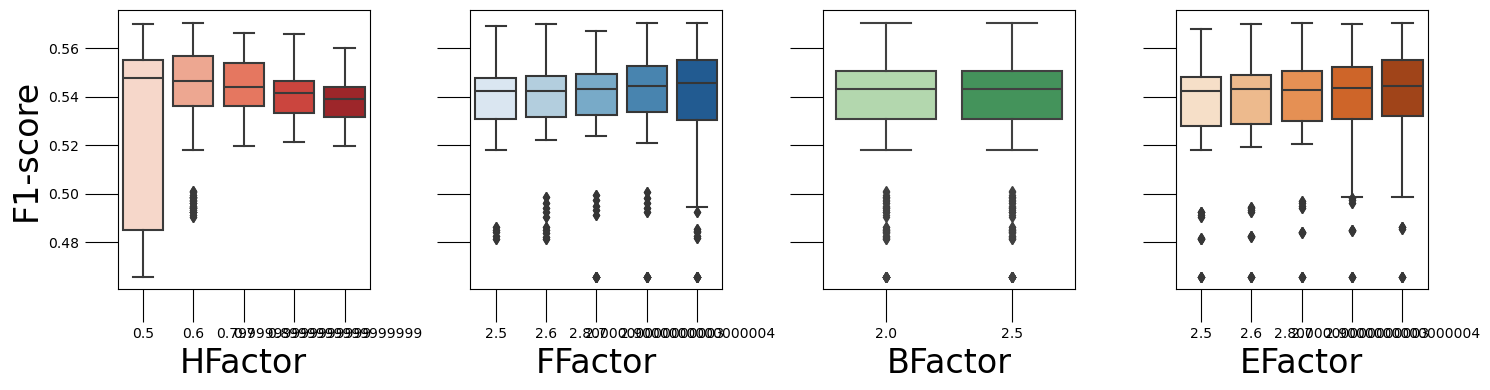

In [ ]:
# F1-score
fig, ax = plt.subplots(1,4, figsize=(15,4), sharey=True)

for i, (metric, cmap) in enumerate(zip(['HFactor', 'FFactor', 'BFactor', 'EFactor'], ['Reds','Blues','Greens','Oranges'])):
    
    sns.boxplot(data=results_df, x=metric, y='F1', palette=cmap, ax=ax[i])
    
    ax[i].tick_params(axis='both', size=24)
    ax[i].set_ylabel('', size=24)
    ax[i].set_xlabel(metric, size=24)

ax[0].set_ylabel('F1-score', size=24)
plt.tight_layout()
plt.show()    

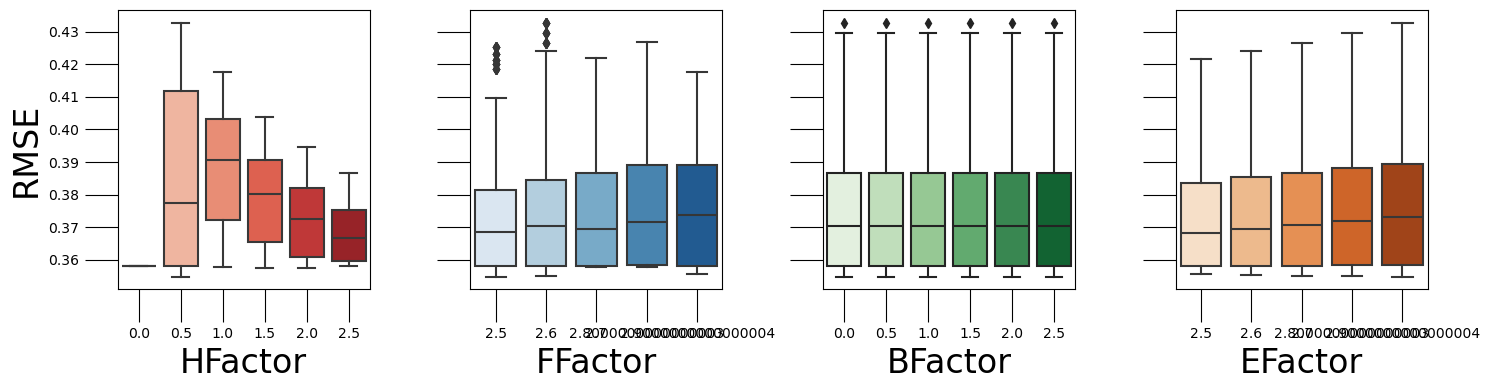

In [ ]:
# RMSE
results_df['RMSE'] = np.sqrt(results_df['MSE'])

fig, ax = plt.subplots(1,4, figsize=(15,4), sharey=True)

for i, (metric, cmap) in enumerate(zip(['HFactor', 'FFactor', 'BFactor', 'EFactor'], ['Reds','Blues','Greens','Oranges'])):
    
    sns.boxplot(data=results_df, x=metric, y='RMSE', palette=cmap, ax=ax[i])
    
    ax[i].tick_params(axis='both', size=24)
    ax[i].set_ylabel('', size=24)
    ax[i].set_xlabel(metric, size=24)

ax[0].set_ylabel('RMSE', size=24)
plt.tight_layout()
plt.show()    

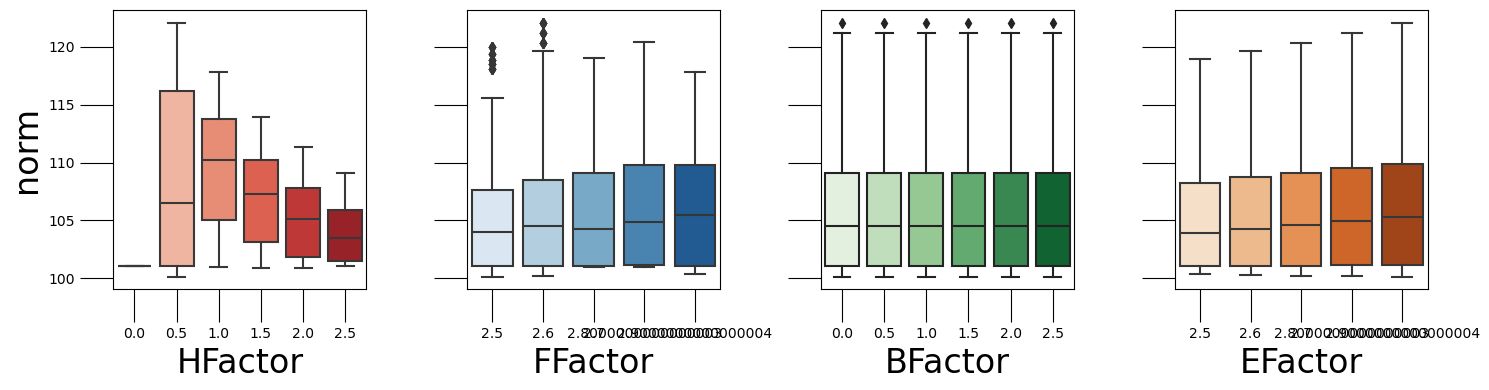

In [ ]:
# Norm
fig, ax = plt.subplots(1,4, figsize=(15,4), sharey=True)

for i, (metric, cmap) in enumerate(zip(['HFactor', 'FFactor', 'BFactor', 'EFactor'], ['Reds','Blues','Greens','Oranges'])):
    
    sns.boxplot(data=results_df, x=metric, y='norm', palette=cmap, ax=ax[i])
    
    ax[i].tick_params(axis='both', size=24)
    ax[i].set_ylabel('', size=24)
    ax[i].set_xlabel(metric, size=24)

ax[0].set_ylabel('norm', size=24)
plt.tight_layout()
plt.show()    

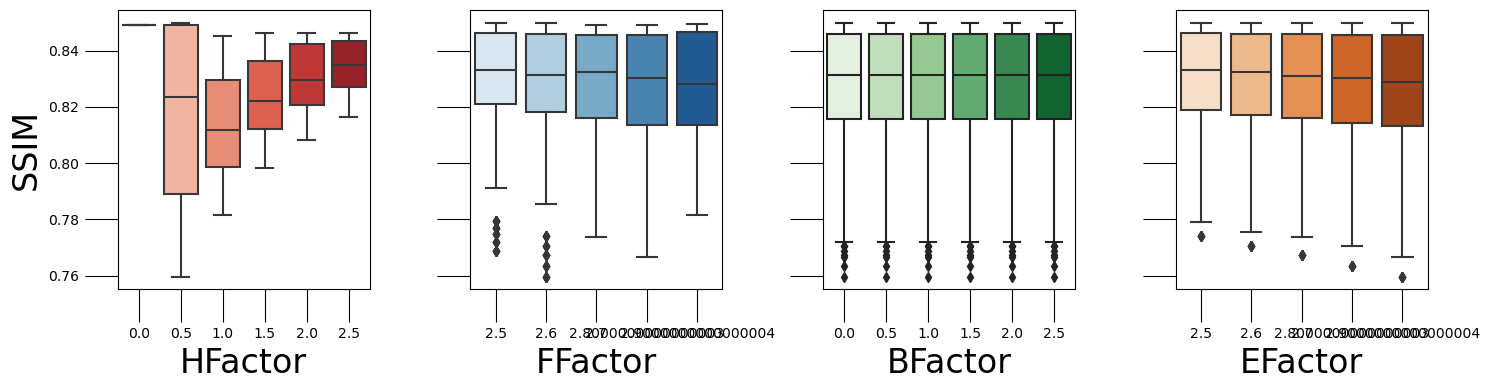

In [ ]:
# SSIM
fig, ax = plt.subplots(1,4, figsize=(15,4), sharey=True)

for i, (metric, cmap) in enumerate(zip(['HFactor', 'FFactor', 'BFactor', 'EFactor'], ['Reds','Blues','Greens','Oranges'])):
    
    sns.boxplot(data=results_df, x=metric, y='SSIM', palette=cmap, ax=ax[i])
    
    ax[i].tick_params(axis='both', size=24)
    ax[i].set_ylabel('', size=24)
    ax[i].set_xlabel(metric, size=24)

ax[0].set_ylabel('SSIM', size=24)
plt.tight_layout()
plt.show()    

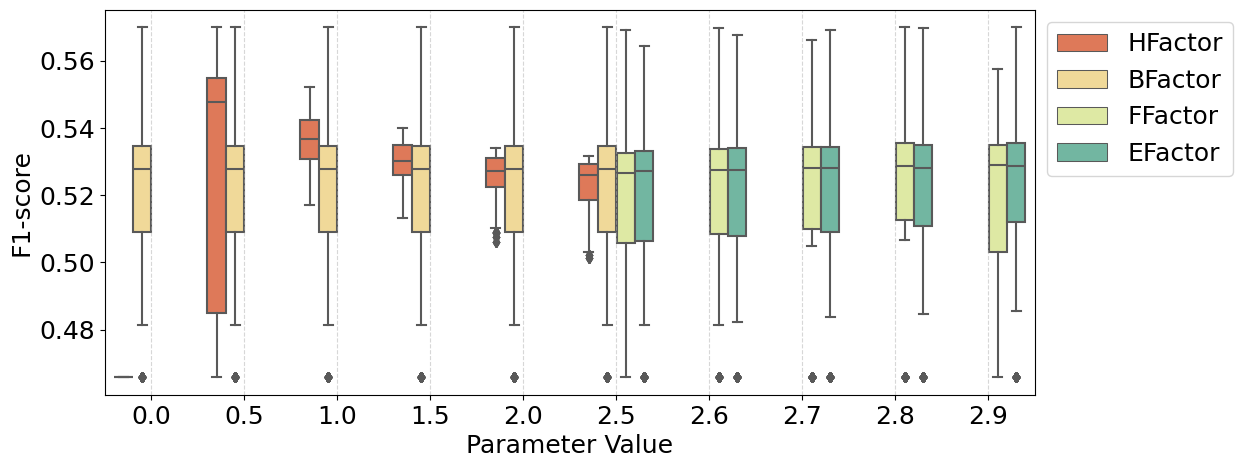

In [ ]:
df = results_df[['HFactor', 'BFactor', 'FFactor', 'EFactor', 'F1']]
df.iloc[:, :-1] = df.iloc[:, :-1].round(1)  # Round all columns except 'F1'

fig, ax = plt.subplots(1, figsize=(12,5))

df_melted = df.melt(id_vars="F1", var_name="Factor", value_name="Factor Value")

# Convert to categorical to maintain order
df_melted["Factor Value"] = df_melted["Factor Value"]

sns.boxplot(x="Factor Value", y="F1", hue="Factor", palette='Spectral', data=df_melted, ax=ax)

ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel("Parameter Value", size=18)
ax.set_ylabel("F1-score", size=18)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 18})

# Align grid with categorical x-axis labels
ax.set_xticks(range(len(df_melted["Factor Value"].unique())))
ax.set_xticklabels(sorted(df_melted["Factor Value"].unique()))  # Ensure order
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.show()

In [ ]:
results_df.sort_values(by='F1', ascending=False)

,Instance,HFactor,BFactor,FFactor,EFactor,fperiod,ADI,ADI_ue,ADIoe,F1,norm,MSE,area_c2f,SSIM,area_ref,time,RMSE
979,979,0.5,1.5,2.8,2.9,0.4,6.211901,3.370719,2.841182,0.569964,120.461612,0.182274,8973,0.766508,10210,2.144572,0.426935
879,879,0.5,1.0,2.8,2.9,0.4,6.211901,3.370719,2.841182,0.569964,120.461612,0.182274,8973,0.766508,10210,2.015767,0.426935
679,679,0.5,0.0,2.8,2.9,0.4,6.211901,3.370719,2.841182,0.569964,120.461612,0.182274,8973,0.766508,10210,2.082313,0.426935
779,779,0.5,0.5,2.8,2.9,0.4,6.211901,3.370719,2.841182,0.569964,120.461612,0.182274,8973,0.766508,10210,2.292135,0.426935
1079,1079,0.5,2.0,2.8,2.9,0.4,6.211901,3.370719,2.841182,0.569964,120.461612,0.182274,8973,0.766508,10210,2.021726,0.426935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,427,0.0,2.0,2.6,2.6,0.4,10209.000000,10209.000000,0.000000,0.465842,101.039596,0.128236,1,0.849267,10210,0.545427,0.358101
426,426,0.0,2.0,2.6,2.6,0.3,10209.000000,10209.000000,0.000000,0.465842,101.039596,0.128236,1,0.849267,10210,0.550806,0.358101
425,425,0.0,2.0,2.6,2.6,0.2,10209.000000,10209.000000,0.000000,0.465842,101.039596,0.128236,1,0.849267,10210,0.545625,0.358101
424,424,0.0,2.0,2.6,2.6,0.1,10209.000000,10209.000000,0.000000,0.465842,101.039596,0.128236,1,0.849267,10210,0.546384,0.358101
